__Note__: In-development notebook.

# Introduction

In this notebook, we aim at comparing various baselines approaches for Learnong to Run a Power Network. As such, we conduct several same-context experiments on four baselines solutions. The first section of this document gives insight about the context of the experiment, including the initial power grid used, and the shape of the injections. The second section defines four baselines solutions, which include a do-nothing agent, two random action models and a greedy branch disconnection agent. Finally, we infer some statistics about the performance of those models.

Please refer to the associated master thesis report (available at https://github.com/MarvinLer/L2RPN_env/blob/dev/doc/LEROUSSEAU_Marvin_report_master_thesis.pdf) for an introduction to this project.

In [47]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
import numpy as np
import sys
import os
sys.path.append(os.path.abspath("../"))

## Usage example with the game environment
This subsection is intended to display a basic usage of the proposed game environment. We constructed it on the same overall API than the gym environment of OpenAI (https://gym.openai.com), so that our environment can be integrated with the library (which notably contain some RL algorithms implementation).

The overall basic usage example, given a policy $\Pi$:

In [2]:
from src.env import RunEnv

# Start the game environment with the grid case14, made of 14 substations
env = RunEnv(grid_case=14)
observation = env._get_obs()  # Initial observation

Π = lambda x: None  # Policy

done = True
while not done:
    action = Π(observation)
    observation, reward, done, info = env.step(action)
    
    if info is not None:
        print('Game over!', info)
        pass  # Here you can do things to debug your solution

Using chronics folder /home/marvin/Documents/pro/stagemaster_inria/PowerGrid-UI/input/chronics/14 and reference grid /home/marvin/Documents/pro/stagemaster_inria/PowerGrid-UI/input/reference_grid14.m


# Context of the experiments

We plan to compare the performance of raw baselines approaches to the problem, that do not take advantage of any training. We define later the explicit behavior of the four baselines to be compared. We design here an experiment that will be conducted by all of the baselines, for fairness in the subsequent comparisons.

## Grid used

More explicitaly, the players (or agents) will have to operate a grid known as IEEE-14, also called case14 (officially IEEE-14), which is one of the simplified version of the California power grid. Explicitely, case14 is made of:
* 14 substations
* 5 generators
* 7 consumptions
* 20 branches

Here is a representation of the overall shape of the case14.

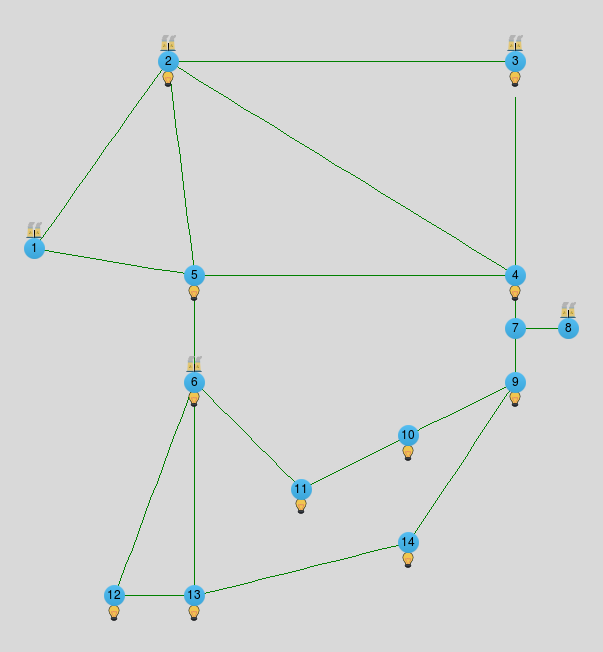

Additional experiment settings:
* Throughout the game, every line has a thermal limit of 1250 (but this information is not explicitely given to the players or the challengers).
* The load-flow is on AC mode, such that lines are lossless for instance
* Cascading failure simulations are limited to a depth of 3
* By construction, we set the reward related to a load cut (i.e. grid not connexe reward) equal to -5

Apart from the thermal limits and the values of the injections plus the flows, the grid parameters (resistance, reactance etc.) are available at https://github.com/MATPOWER/matpower/blob/master/data/case14.m.

## Input chronics
We use predefined values for the injections chronic. Randomly, some productions can be switched-off (output is then 0), which brings some randomness in the data. However, the data was constructed using seasonality, including daily and weekly seasonality (which is usually the case in real-life, e.g. a peak of consumption at 7pm).

Here, we plots the sum of productions per timestep (note that eventually, this code will not be runnable by the challengers):

Number of productions 5

Number of timesteps 8726

First set of productions: [2458.4128  998.1634  751.4649  775.6172  787.9434]


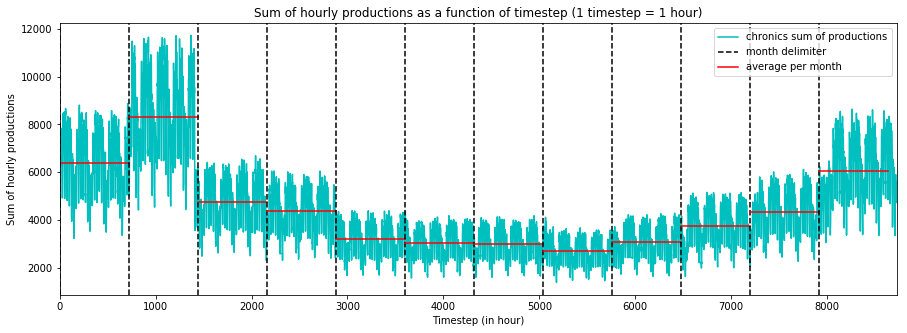

In [48]:
planned_productions = env.game.chronic.prods_p
print('Number of productions', len(planned_productions[0]))
print('\nNumber of timesteps', len(planned_productions))
print('\nFirst set of productions:', planned_productions[0])

# Plotting the sum of productions for each timestep
sum_productions = np.array([sum(p) for p in planned_productions])
plt.plot(np.arange(1, len(planned_productions)+1), sum_productions, color='c', label='chronics sum of productions')
plt.xlim([0, len(planned_productions)])
# Plot month vertical bars: approx one every 30 days; plot also average productions per month
for i in range(12):
    plt.axvline(x=30*24*i, color='k', linestyle='--', label='month delimiter' if i == 0 else None)  # 30*24 because chronics are hourly updates
    plt.plot(np.arange(30*24*i, 30*24*(i+1)), [sum(sum_productions[30*24*i:30*24*(i+1)+1])/(30.*24.)]*30*24, color='r', label='average per month' if i == 0 else None)
    
plt.ylabel('Sum of hourly productions')
plt.xlabel('Timestep (in hour)')
plt.title('Sum of hourly productions as a function of timestep (1 timestep = 1 hour)')
plt.legend(loc='best')

### Zoom on the month of January

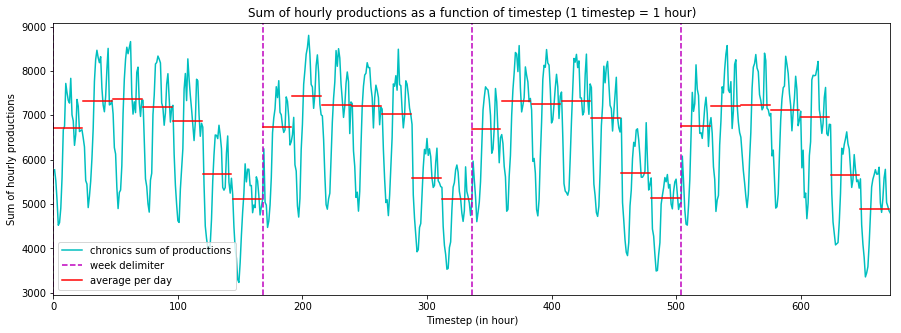

In [49]:
length = 28*24
lengthweek = 7*24
lengthday = 24
planned_productions = planned_productions[:length]

# Plotting the sum of productions for each timestep
hourlysum_productions = np.array([sum(p) for p in planned_productions])
plt.plot(np.arange(1, len(planned_productions)+1), hourlysum_productions, color='c', label='chronics sum of productions')
plt.xlim([0, len(planned_productions)])
# Plot week vertical bars: approx one every 30 days; plot also average productions per month
for i in range(4):
    plt.axvline(x=7*24*i, color='m', linestyle='--', label='week delimiter' if i == 0 else None)  # 30*24 because chronics are hourly updates
    
for j in range(4*7):
    plt.plot(np.arange(lengthday*j, lengthday*(j+1)), [sum(hourlysum_productions[lengthday*j:lengthday*(j+1)+1])/(float(lengthday))]*lengthday, color='r', label='average per day' if j == 0 else None)    
    
plt.ylabel('Sum of hourly productions')
plt.xlabel('Timestep (in hour)')
plt.title('Sum of hourly productions as a function of timestep (1 timestep = 1 hour)')
plt.legend(loc='best')

## Code of the common experiment
All of the baselines will be fed scenarios with the same injections values. Theorically, the grid photos will be different along the baselines since a grid state depends on the actions of a player.

We define here the function that runs a policy Π for our proposed experiment, which lasts for 1000 timesteps:

In [30]:
n_timesteps = 2000
np.random.seed(123)

def run_policy(Π):
    env = RunEnv(grid_case=14)
    observation = env._get_obs()  # Initial observation
    
    # Keep rewards stats
    rewards = []

    current = 0
    while current < n_timesteps:
        action = Π(env, observation)
        observation, reward, done, info = env.step(action)
        
        # Save stats
        rewards.append(reward)
        current += 1
        print('timestep', format(current, '04d'), ' total reward:', np.sum(rewards))
        
        if done:
            observation = env.reset(restart=False)  # Do not restart the game from the initial state
            print('Game over! info:', info)
            continue
    
    return np.asarray(rewards)

## Hyperparameters
The reward is based on the sum of 4 subrewards related to:
* Line capacity usage
* Load cuts
* Grid connexity or loadflow error
* Cost of action
* Distance to the reference grid

In [31]:
print('line capacity multiplicatif factor:', env.multiplicative_factor_line_usage_reward)
print('grid connexity and loadflow error:', env.connexity_exception_reward, env.loadflow_exception_reward)
print('cost of switch off, cost of node-splitting:', env.cost_line_switch, env.cost_node_switch)
print('cost of switch off, cost of node-splitting:', env.cost_line_switch, env.cost_node_switch)
print('load cut not yet implemented')

line capacity multiplicatif factor: -1.0
grid connexity and loadflow error: -14 -14
cost of switch off, cost of node-splitting: 0 0
cost of switch off, cost of node-splitting: 0 0
load cut not yet implemented


# Baselines approaches

We propose four baselines that are all based on hand-crafted policies that do not learn (i.e. no learning parameters). In this section, we define and code each baseline such that they are integrated with our proposed game environment. Specifically, we are intersted in code a policy that takes an observation $o_t$ and returns an action $a_t$:
$$
\Pi(a_t|o_t)
$$

To do so, all of the baselines have a function baseline_name_policy which takes a state, and output an action. The four baselines are:
* Do-nothing policy: performs no action whatsoever
* Random line switch off policy: at each timestep, randomly disconnect one line (and reconnect it back for next timestep)
* Random node splitting policy: at each timestep, randomly change the topological configuration of one random substation
* Tree-search line switch-off policy: at each timestep, will simulate the state of the grid with one and only one switched-off line, for all lines

These baselines policies are rudimentary because:
* they do not learn,
* the output action do not depend on the current state of the grid $\Pi(a_t|o_t)=\Pi(a_t)$.

## Do-nothing policy
The Agent does not perform any action:

$$
\Pi(a_t|o_t) = \varnothing
$$

Here is its implementation:

In [32]:
def do_nothing_policy(env, observation_t):
    return None

## Random line switch-off policy
The Agent randomly switch-off one line at each timestep. For this task, the topological subaction is None, and the line service status is made of one 0 value, all the others being 1. The 0 value indicate a line to be switched off. Its policy is:

$$
\Pi(a_t|o_t) = [a_t^1, a_t^2]\\
a_t^1=0 \in \{0, 1\}^{n_\mathrm{prods}+n_\mathrm{loads}+2*n_\mathrm{lines}}\\
a_t^2 \in \{0, 1\}^{n_\mathrm{lines}}\mathrm{ s.t. }\exists !i, a_{t, i}^2 = 1\\
$$
In plain words, the action output is a list of two concatenated lists: the first one (concerning nodes on which elements are connected) is 0, the second one is a one-hot vector, where the active component indicates the line status to switch.

The policy can be implemented as:

In [33]:
def random_switch_off_policy(env, observation_t):
    nodes_subaction = np.zeros((env.action_space.n - env.action_space.n_lines,))
    
    status_subaction = np.zeros((env.action_space.n_lines,))
    status_subaction[np.random.randint(len(status_subaction))] = 1
    
    return np.concatenate((nodes_subaction, status_subaction,))

## Random node-splitting policy
This Agent is constraint to output node-splitting actions: the subaction of line service status is always None. Specifically, at each timestep, the Agent first chose a random substation. Then, it chose a random configuration for the latter. Its policy can be formulated as:


$$
\Pi(a_t|o_t) = [a_t^1, a_t^2]\\
a_t^1=0 \in \{0, 1\}^{n_\mathrm{prods}+n_\mathrm{loads}+2*n_\mathrm{lines}}\mathrm{ s.t. }\exists !i, a_{t, i}^1 = 1\\
a_t^2 \in \{0, 1\}^{n_\mathrm{lines}}\\
$$

$$
\Pi(a_t|o_t) = \{a_t^1, \varnothing\}
$$

with $a_t^1=[None, ..., None]$ and $a_t^1[U(1, n_{substations})]=ns$, where $U(a, b)$ is a discrete uniform distribution that returns a random integer between a and b (inclusive here), and $ns$ is a one-hot vector of size the number of possible configurations for the selected substation. Note that some substation only have one bus (or node) where objects can be directly connected (e.g. a substation with at most three elements); the policy do not care about this (and in such a substation, will naturally output a vector [1]).

The policy can be implemented as:

In [34]:
def random_node_splitting_policy(env, observation_t):
    nodes_subaction = np.zeros((env.action_space.n - env.action_space.n_lines,))
    nodes_subaction[np.random.randint(len(nodes_subaction))] = 1
    
    status_subaction = np.zeros((env.action_space.n_lines,))
    
    return np.concatenate((nodes_subaction, status_subaction,))

## Tree-search line switch-off policy
At each timestep $t$, the Agent will simulate every possible line switch-off $a_{i, t}^2$, and retrieve the reward $R(s_t, a_{i, t}^2)$. More precisaly, given a grid configuration where all lines are switched-on, the agent will compute
$$
r_i = R(s_t, a_{i, t}^2)
$$
then
$$
a_t = argmax_{a_{i, t}^2} R(s_t, a_{i, t}^2)
$$
where $a_{i, t}^2$ is the line switched-off subaction, such that only line $i$ is switched-off. This Agent is apparent to a greedy policy, where the Action Space is constrained to switches-off.

The policy can be implemented as:

In [35]:
def treesearch_switched_off_policy(env, observation_t):
    # Action related to lines service status
    action_size = env.action_space.n
    n_lines = env.action_space.n_lines
    topology_subaction = np.zeros((action_size - n_lines,))
    
    # Retrieves every reward related to every 1-switch-off action
    timestep_rewards = []
    for l in range(n_lines):
        env.game.grid.filename = 'swoff_line%d.m'%l
        print(' Simulation with line %d switched off' % l)
        line_service_subaction = np.zeros((n_lines,))
        line_service_subaction[l] = 1  # Toggle line l
        
        # Construct the action based on two subactions and launch simulation
        action = np.concatenate((topology_subaction, line_service_subaction))
        simulated_reward = env.simulate(action)
        
        timestep_rewards.append(simulated_reward)
    # Compute and append reward of no action
    print(' Simulation with no action')
    env.game.grid.filename = 'nothing.m'
    simulated_reward = env.simulate(None)
    timestep_rewards.append(simulated_reward)
    
    # Get the action that maximizes the reward (construct it based on max of stored rewards)
    argmax_reward = np.argmax(timestep_rewards)
    print('rewards', timestep_rewards, 'argmax', argmax_reward)
    # If last action is best, return no action
    if argmax_reward == len(timestep_rewards)-1:
        print('Action chosen: no action')
        return None
    
    # Else, recompute line status toggle that maximizes reward for this timestep
    line_service_subaction = np.zeros((n_lines,))
    line_service_subaction[argmax_reward] = 1
    action = np.concatenate((topology_subaction, line_service_subaction))
    
    print('Action chosen: switching off line', argmax_reward)
    
    return action

# Baselines comparisons

## Running the policies

In [36]:
rewards_do_nothing = run_policy(do_nothing_policy)

Using chronics folder /home/marvin/Documents/pro/stagemaster_inria/PowerGrid-UI/input/chronics/14 and reference grid /home/marvin/Documents/pro/stagemaster_inria/PowerGrid-UI/input/reference_grid14.m
  Simulating cascading failure
  ok
timestep 0001  total reward: -2.0592410779149573
  Simulating cascading failure
  ok
timestep 0002  total reward: -3.9590646423422813
  Simulating cascading failure
  ok
timestep 0003  total reward: -5.465057867879118
  Simulating cascading failure
  ok
timestep 0004  total reward: -6.985098680162699
  Simulating cascading failure
  ok
timestep 0005  total reward: -8.59357179288142
  Simulating cascading failure
  ok
timestep 0006  total reward: -10.312693429902543
  Simulating cascading failure
  ok
timestep 0007  total reward: -12.337225754464619
  Simulating cascading failure
  ok
timestep 0008  total reward: -14.786425303525743
  Simulating cascading failure
  ok
timestep 0009  total reward: -17.773621161328332
  Simulating cascading failure
  ok
tim

  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 1 overflowed lines
timestep 0091  total reward: -302.5264692527152
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 0092  total reward: -305.9537900790773
  Simulating cascading failure
  ok
timestep 0093  total reward: -308.84752867432445
  Simulating cascading failure
  ok
timestep 0094  total reward: -311.6094733335332
  Simulating cascading failure
  ok
timestep 0095  total reward: -314.5602368077107
  Simulating cascading failure
  ok
timestep 0096  total reward: -317.1570705365157
  Simulating cascading failure
  ok
timestep 0097  total reward: -318.67625794305957
  Simulating cascading failure
  ok
timestep 0098  total reward: -319.74916215910775
  Simulating cascading failure
  ok
timestep 0099  total reward: -321.0146491355524
  Simulating cascading failure
  ok
timestep 0100  total reward: -322.2161164137262
  Simulating cascading fa

  Simulating cascading failure
  ok
timestep 0187  total reward: -504.9509058716004
  Simulating cascading failure
  ok
timestep 0188  total reward: -507.9534991706141
  Simulating cascading failure
  ok
timestep 0189  total reward: -511.09102988657355
  Simulating cascading failure
  ok
timestep 0190  total reward: -513.2200950994402
  Simulating cascading failure
  ok
timestep 0191  total reward: -515.0210700014102
  Simulating cascading failure
  ok
timestep 0192  total reward: -517.4842407779365
  Simulating cascading failure
  ok
timestep 0193  total reward: -519.7335118994905
  Simulating cascading failure
  ok
timestep 0194  total reward: -521.8605977385863
  Simulating cascading failure
  ok
timestep 0195  total reward: -523.7084341489151
  Simulating cascading failure
  ok
timestep 0196  total reward: -525.0199649779646
  Simulating cascading failure
  ok
timestep 0197  total reward: -526.3414737325293
  Simulating cascading failure
  ok
timestep 0198  total reward: -528.15047

timestep 0283  total reward: -788.7251858633142
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 1 overflowed lines
timestep 0284  total reward: -802.7251858633142
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 0285  total reward: -805.7638274300803
  Simulating cascading failure
  ok
timestep 0286  total reward: -808.5457974793902
  Simulating cascading failure
  ok
timestep 0287  total reward: -811.0991451593201
  Simulating cascading failure
  ok
timestep 0288  total reward: -813.0688200419933
  Simulating cascading failure
  ok
timestep 0289  total reward: -814.4175393431636
  Simulating cascading failure
  ok
timestep 0290  total reward: -815.5435097720433
  Simulating cascading failure
  ok
timestep 0291  total reward: -816.5829245137475
  Simulating cascading failure
  ok
timestep 0292  total reward: -817.6692544381874
  Simulating cascading failure
  ok
timestep 0293  total reward:

  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 0373  total reward: -1050.6660856073413
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 0374  total reward: -1064.6660856073413
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 0375  total reward: -1068.7054763727274
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 1 overflowed lines
timestep 0376  total reward: -1082.7054763727274
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 1 overflowed lines
timestep 0377  total reward: -1096.7054763727274
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
    depth 0: 1 o

  Simulating cascading failure
  ok
timestep 0450  total reward: -1405.8290195874354
  Simulating cascading failure
  ok
timestep 0451  total reward: -1409.0614443483162
  Simulating cascading failure
  ok
timestep 0452  total reward: -1412.1933042475694
  Simulating cascading failure
  ok
timestep 0453  total reward: -1414.8522397340344
  Simulating cascading failure
  ok
timestep 0454  total reward: -1417.365792618145
  Simulating cascading failure
  ok
timestep 0455  total reward: -1420.2817980395744
  Simulating cascading failure
  ok
timestep 0456  total reward: -1422.6565607774191
  Simulating cascading failure
  ok
timestep 0457  total reward: -1423.7115541899666
  Simulating cascading failure
  ok
timestep 0458  total reward: -1424.3216452043107
  Simulating cascading failure
  ok
timestep 0459  total reward: -1425.0275647624221
  Simulating cascading failure
  ok
timestep 0460  total reward: -1425.895305175009
  Simulating cascading failure
  ok
timestep 0461  total reward: -1

  Simulating cascading failure
  ok
timestep 0547  total reward: -1608.6637489127943
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 0548  total reward: -1622.6637489127943
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 0549  total reward: -1625.3247789474317
  Simulating cascading failure
  ok
timestep 0550  total reward: -1627.8031646271397
  Simulating cascading failure
  ok
timestep 0551  total reward: -1629.6398101824607
  Simulating cascading failure
  ok
timestep 0552  total reward: -1631.3068928627904
  Simulating cascading failure
  ok
timestep 0553  total reward: -1633.7787902960415
  Simulating cascading failure
  ok
timestep 0554  total reward: -1636.0763074674633
  Simulating cascading failure
  ok
timestep 0555  total reward: -1637.7195285864384
  Simulating cascading failure
  ok
timestep 0556  total reward: -1639.1824796519404
  Simulating casca

  Simulating cascading failure
  ok
timestep 0639  total reward: -1879.173155901645
  Simulating cascading failure
  ok
timestep 0640  total reward: -1880.907583994541
  Simulating cascading failure
  ok
timestep 0641  total reward: -1882.580890394408
  Simulating cascading failure
  ok
timestep 0642  total reward: -1884.8756425060328
  Simulating cascading failure
  ok
timestep 0643  total reward: -1887.1676479455225
  Simulating cascading failure
  ok
timestep 0644  total reward: -1889.2016461049643
  Simulating cascading failure
  ok
timestep 0645  total reward: -1890.8767400022455
  Simulating cascading failure
  ok
timestep 0646  total reward: -1892.3580891314875
  Simulating cascading failure
  ok
timestep 0647  total reward: -1894.1692545960605
  Simulating cascading failure
  ok
timestep 0648  total reward: -1895.8270525890337
  Simulating cascading failure
  ok
timestep 0649  total reward: -1897.106482578111
  Simulating cascading failure
  ok
timestep 0650  total reward: -189

  Simulating cascading failure
  ok
timestep 0733  total reward: -2112.9544414423563
  Simulating cascading failure
  ok
timestep 0734  total reward: -2116.040716600347
  Simulating cascading failure
  ok
timestep 0735  total reward: -2118.7885765307055
  Simulating cascading failure
  ok
timestep 0736  total reward: -2121.5013468220795
  Simulating cascading failure
  ok
timestep 0737  total reward: -2124.48609843047
  Simulating cascading failure
  ok
timestep 0738  total reward: -2127.585863536416
  Simulating cascading failure
  ok
timestep 0739  total reward: -2131.0380037777763
  Simulating cascading failure
  ok
timestep 0740  total reward: -2135.0090382334333
  Simulating cascading failure
  ok
timestep 0741  total reward: -2138.27806066151
  Simulating cascading failure
  ok
timestep 0742  total reward: -2141.3615556060167
  Simulating cascading failure
  ok
timestep 0743  total reward: -2144.5782452716885
  Simulating cascading failure
  ok
timestep 0744  total reward: -2147.

timestep 0805  total reward: -2546.416958402441
  Simulating cascading failure
  ok
timestep 0806  total reward: -2550.110228769617
  Simulating cascading failure
  ok
timestep 0807  total reward: -2553.131336130393
  Simulating cascading failure
  ok
timestep 0808  total reward: -2555.9605054190015
  Simulating cascading failure
  ok
timestep 0809  total reward: -2559.1926762517896
  Simulating cascading failure
  ok
timestep 0810  total reward: -2563.0890531714867
  Simulating cascading failure
  ok
timestep 0811  total reward: -2567.103305810012
  Simulating cascading failure
  ok
timestep 0812  total reward: -2571.3141066315447
  Simulating cascading failure
  ok
timestep 0813  total reward: -2575.109072158282
  Simulating cascading failure
  ok
timestep 0814  total reward: -2578.2681274197766
  Simulating cascading failure
  ok
timestep 0815  total reward: -2581.572918959281
  Simulating cascading failure
  ok
timestep 0816  total reward: -2584.078666333784
  Simulating cascading 

timestep 0882  total reward: -2947.2166072207683
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 0883  total reward: -2961.2166072207683
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 0884  total reward: -2967.0841090775525
  Simulating cascading failure
  ok
timestep 0885  total reward: -2971.8519377094485
  Simulating cascading failure
  ok
timestep 0886  total reward: -2976.3909063886126
  Simulating cascading failure
  ok
timestep 0887  total reward: -2981.435282008542
  Simulating cascading failure
  ok
timestep 0888  total reward: -2985.9148357075446
  Simulating cascading failure
  ok
timestep 0889  total reward: -2989.850826704019
  Simulating cascading failure
  ok
timestep 0890  total reward: -2993.822912102459
  Simulating cascading failure
  ok
timestep 0891  total reward: -2997.007780410875
  Simulating cascading failure
  ok
timestep 0892  total r

Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 0951  total reward: -3443.180155475647
  Simulating cascading failure
  ok
timestep 0952  total reward: -3447.6921645870752
  Simulating cascading failure
  ok
timestep 0953  total reward: -3452.052365817862
  Simulating cascading failure
  ok
timestep 0954  total reward: -3457.746582987608
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 0955  total reward: -3471.746582987608
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 0956  total reward: -3485.746582987608
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 0957  total reward: -3490.6660154578312
  Simulating cascading failure
  ok
timestep 0958  total reward: -3495.48

timestep 1036  total reward: -3797.3670125180706
  Simulating cascading failure
  ok
timestep 1037  total reward: -3799.272339668906
  Simulating cascading failure
  ok
timestep 1038  total reward: -3803.1011825108017
  Simulating cascading failure
  ok
timestep 1039  total reward: -3808.6791104089207
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 1040  total reward: -3822.679110408921
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 1041  total reward: -3836.679110408921
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 1042  total reward: -3843.3814637306814
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 1043  total reward: -3857.3814637306814
Game over! info: Cascading failure o

Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 1096  total reward: -4302.650572018049
  Simulating cascading failure
  ok
timestep 1097  total reward: -4307.902549293333
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 1098  total reward: -4321.902549293333
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 1099  total reward: -4335.902549293333
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 1100  total reward: -4349.902549293333
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 1101  total reward: -4354.7446549799715
  Simulating cascading fai

  Simulating cascading failure
  ok
timestep 1173  total reward: -4696.9664859237055
  Simulating cascading failure
  ok
timestep 1174  total reward: -4699.2597018436445
  Simulating cascading failure
  ok
timestep 1175  total reward: -4701.612014273391
  Simulating cascading failure
  ok
timestep 1176  total reward: -4704.560001835401
  Simulating cascading failure
  ok
timestep 1177  total reward: -4707.785456238714
  Simulating cascading failure
  ok
timestep 1178  total reward: -4710.522297359081
  Simulating cascading failure
  ok
timestep 1179  total reward: -4712.793008816983
  Simulating cascading failure
  ok
timestep 1180  total reward: -4714.815717744404
  Simulating cascading failure
  ok
timestep 1181  total reward: -4717.009388418222
  Simulating cascading failure
  ok
timestep 1182  total reward: -4719.826518626706
  Simulating cascading failure
  ok
timestep 1183  total reward: -4723.668174831537
  Simulating cascading failure
  ok
timestep 1184  total reward: -4728.476

  Simulating cascading failure
  ok
timestep 1244  total reward: -5114.814245986461
  Simulating cascading failure
  ok
timestep 1245  total reward: -5117.843290041941
  Simulating cascading failure
  ok
timestep 1246  total reward: -5122.392628353322
  Simulating cascading failure
  ok
timestep 1247  total reward: -5128.306942037851
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 1248  total reward: -5142.30694203785
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 1249  total reward: -5156.30694203785
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 1250  total reward: -5170.30694203785
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascad

  Simulating cascading failure
  ok
timestep 1315  total reward: -5550.163597238753
  Simulating cascading failure
  ok
timestep 1316  total reward: -5551.723103229203
  Simulating cascading failure
  ok
timestep 1317  total reward: -5553.846009221843
  Simulating cascading failure
  ok
timestep 1318  total reward: -5556.37759304821
  Simulating cascading failure
  ok
timestep 1319  total reward: -5559.121774848838
  Simulating cascading failure
  ok
timestep 1320  total reward: -5562.417227854759
  Simulating cascading failure
  ok
timestep 1321  total reward: -5565.989057621311
  Simulating cascading failure
  ok
timestep 1322  total reward: -5569.431171882334
  Simulating cascading failure
  ok
timestep 1323  total reward: -5572.6124085210995
  Simulating cascading failure
  ok
timestep 1324  total reward: -5575.8575717767235
  Simulating cascading failure
  ok
timestep 1325  total reward: -5578.878232250825
  Simulating cascading failure
  ok
timestep 1326  total reward: -5581.2795

  Simulating cascading failure
  ok
timestep 1386  total reward: -5990.847538273279
  Simulating cascading failure
  ok
timestep 1387  total reward: -5993.391871350301
  Simulating cascading failure
  ok
timestep 1388  total reward: -5996.647572033497
  Simulating cascading failure
  ok
timestep 1389  total reward: -6000.837545819685
  Simulating cascading failure
  ok
timestep 1390  total reward: -6006.060936547915
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 1391  total reward: -6020.060936547915
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 1392  total reward: -6034.060936547915
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 1393  total reward: -6048.060936547915
Game 

timestep 1468  total reward: -6265.629974759732
  Simulating cascading failure
  ok
timestep 1469  total reward: -6266.713071584179
  Simulating cascading failure
  ok
timestep 1470  total reward: -6267.76977620836
  Simulating cascading failure
  ok
timestep 1471  total reward: -6268.76229151293
  Simulating cascading failure
  ok
timestep 1472  total reward: -6269.931974688637
  Simulating cascading failure
  ok
timestep 1473  total reward: -6271.275687287381
  Simulating cascading failure
  ok
timestep 1474  total reward: -6272.436276251987
  Simulating cascading failure
  ok
timestep 1475  total reward: -6273.411594214623
  Simulating cascading failure
  ok
timestep 1476  total reward: -6274.364086130324
  Simulating cascading failure
  ok
timestep 1477  total reward: -6275.343941360201
  Simulating cascading failure
  ok
timestep 1478  total reward: -6276.12043642717
  Simulating cascading failure
  ok
timestep 1479  total reward: -6276.669034858676
  Simulating cascading failure


timestep 1566  total reward: -6396.381821051211
  Simulating cascading failure
  ok
timestep 1567  total reward: -6397.940496395742
  Simulating cascading failure
  ok
timestep 1568  total reward: -6399.649523052515
  Simulating cascading failure
  ok
timestep 1569  total reward: -6401.701181767614
  Simulating cascading failure
  ok
timestep 1570  total reward: -6403.656260349888
  Simulating cascading failure
  ok
timestep 1571  total reward: -6405.321920250433
  Simulating cascading failure
  ok
timestep 1572  total reward: -6406.950884248461
  Simulating cascading failure
  ok
timestep 1573  total reward: -6408.521978814231
  Simulating cascading failure
  ok
timestep 1574  total reward: -6409.915940291758
  Simulating cascading failure
  ok
timestep 1575  total reward: -6411.107181833715
  Simulating cascading failure
  ok
timestep 1576  total reward: -6412.12769382197
  Simulating cascading failure
  ok
timestep 1577  total reward: -6413.079088468478
  Simulating cascading failur

timestep 1664  total reward: -6526.323400108344
  Simulating cascading failure
  ok
timestep 1665  total reward: -6527.396507407675
  Simulating cascading failure
  ok
timestep 1666  total reward: -6528.475312858556
  Simulating cascading failure
  ok
timestep 1667  total reward: -6529.338248564042
  Simulating cascading failure
  ok
timestep 1668  total reward: -6530.185990228254
  Simulating cascading failure
  ok
timestep 1669  total reward: -6531.079778436877
  Simulating cascading failure
  ok
timestep 1670  total reward: -6532.300930058075
  Simulating cascading failure
  ok
timestep 1671  total reward: -6533.532025259328
  Simulating cascading failure
  ok
timestep 1672  total reward: -6534.428367562917
  Simulating cascading failure
  ok
timestep 1673  total reward: -6535.245054341278
  Simulating cascading failure
  ok
timestep 1674  total reward: -6535.941262917544
  Simulating cascading failure
  ok
timestep 1675  total reward: -6536.624112061091
  Simulating cascading failu

timestep 1762  total reward: -6681.626265090364
  Simulating cascading failure
  ok
timestep 1763  total reward: -6683.345916906551
  Simulating cascading failure
  ok
timestep 1764  total reward: -6685.114630296997
  Simulating cascading failure
  ok
timestep 1765  total reward: -6686.673646605276
  Simulating cascading failure
  ok
timestep 1766  total reward: -6688.129743187825
  Simulating cascading failure
  ok
timestep 1767  total reward: -6689.407495327749
  Simulating cascading failure
  ok
timestep 1768  total reward: -6690.381011148784
  Simulating cascading failure
  ok
timestep 1769  total reward: -6691.202689387817
  Simulating cascading failure
  ok
timestep 1770  total reward: -6691.928145245049
  Simulating cascading failure
  ok
timestep 1771  total reward: -6692.685769636886
  Simulating cascading failure
  ok
timestep 1772  total reward: -6693.664440475539
  Simulating cascading failure
  ok
timestep 1773  total reward: -6694.972483608615
  Simulating cascading failu

  Simulating cascading failure
  ok
timestep 1860  total reward: -6799.396911055597
  Simulating cascading failure
  ok
timestep 1861  total reward: -6800.8900413686
  Simulating cascading failure
  ok
timestep 1862  total reward: -6802.345740768408
  Simulating cascading failure
  ok
timestep 1863  total reward: -6803.53352411127
  Simulating cascading failure
  ok
timestep 1864  total reward: -6804.440781349695
  Simulating cascading failure
  ok
timestep 1865  total reward: -6805.287167160219
  Simulating cascading failure
  ok
timestep 1866  total reward: -6806.087018568732
  Simulating cascading failure
  ok
timestep 1867  total reward: -6806.938052236135
  Simulating cascading failure
  ok
timestep 1868  total reward: -6807.962108483236
  Simulating cascading failure
  ok
timestep 1869  total reward: -6809.0003982940125
  Simulating cascading failure
  ok
timestep 1870  total reward: -6810.283105911127
  Simulating cascading failure
  ok
timestep 1871  total reward: -6812.5155423

timestep 1958  total reward: -6955.890254874374
  Simulating cascading failure
  ok
timestep 1959  total reward: -6956.715447871706
  Simulating cascading failure
  ok
timestep 1960  total reward: -6957.475092640752
  Simulating cascading failure
  ok
timestep 1961  total reward: -6958.099113051921
  Simulating cascading failure
  ok
timestep 1962  total reward: -6958.586231879235
  Simulating cascading failure
  ok
timestep 1963  total reward: -6959.12876633785
  Simulating cascading failure
  ok
timestep 1964  total reward: -6959.794838840064
  Simulating cascading failure
  ok
timestep 1965  total reward: -6960.805598675386
  Simulating cascading failure
  ok
timestep 1966  total reward: -6961.9884386283775
  Simulating cascading failure
  ok
timestep 1967  total reward: -6963.1749425705675
  Simulating cascading failure
  ok
timestep 1968  total reward: -6964.491122428017
  Simulating cascading failure
  ok
timestep 1969  total reward: -6966.11314435846
  Simulating cascading failu

In [37]:
rewards_random_switchoff = run_policy(random_switch_off_policy)

Using chronics folder /home/marvin/Documents/pro/stagemaster_inria/PowerGrid-UI/input/chronics/14 and reference grid /home/marvin/Documents/pro/stagemaster_inria/PowerGrid-UI/input/reference_grid14.m
timestep 0001  total reward: -14
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 0002  total reward: -16.858609831495585
  Simulating cascading failure
  ok
timestep 0003  total reward: -18.364603057032422
  Simulating cascading failure
  ok
timestep 0004  total reward: -20.061034580751656
  Simulating cascading failure
  ok
timestep 0005  total reward: -21.88209359307938
  Simulating cascading failure
  ok
timestep 0006  total reward: -24.02606892522541
timestep 0007  total reward: -38.02606892522541
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 0008  total reward: -41.560375980216534
timestep 0009  total reward: -55.560375980216534
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
tim

Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 0081  total reward: -498.8615317425361
  Simulating cascading failure
  ok
timestep 0082  total reward: -503.2900689259014
  Simulating cascading failure
  ok
timestep 0083  total reward: -507.2846146002466
  Simulating cascading failure
  ok
timestep 0084  total reward: -511.7354019125572
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 1 overflowed lines
timestep 0085  total reward: -525.7354019125572
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 0086  total reward: -529.4899326243059
  Simulating cascading failure
  ok
timestep 0087  total reward: -533.199914032528
  Simulating cascading failure
  ok
timestep 0088  total reward: -537.1186233614217
  Simulating cascading failure
  ok
timestep 0089  total reward: -540.9910166016323
  Simulating cascading failure
  ok
time

timestep 0169  total reward: -943.2979095810742
  Simulating cascading failure
  ok
timestep 0170  total reward: -944.9530990037313
  Simulating cascading failure
  ok
timestep 0171  total reward: -946.7166456261402
timestep 0172  total reward: -960.7166456261402
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 0173  total reward: -962.1880815119116
  Simulating cascading failure
  ok
timestep 0174  total reward: -964.0963230872001
  Simulating cascading failure
  ok
timestep 0175  total reward: -966.3028804507146
  Simulating cascading failure
  ok
timestep 0176  total reward: -968.9016718830338
  Simulating cascading failure
  ok
timestep 0177  total reward: -971.7372451672852
  Simulating cascading failure
  ok
timestep 0178  total reward: -974.6753521622542
  Simulating cascading failure
  ok
timestep 0179  total reward: -977.929897450776
  Simulating cascading failure
  ok
timestep 0180  total reward: -981.37187286638
  Simulating cascading fai

Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 0257  total reward: -1418.5726605974855
timestep 0258  total reward: -1432.5726605974855
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 0259  total reward: -1435.6058000163762
  Simulating cascading failure
    depth 0: 1 overflowed lines
timestep 0260  total reward: -1449.6058000163762
Game over! info: Cascading failure of depth 1 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 0261  total reward: -1452.507315475998
  Simulating cascading failure
  ok
timestep 0262  total reward: -1455.8747171726845
  Simulating cascading failure
  ok
timestep 0263  total reward: -1459.5459895477861
  Simulating cascading failure
  ok
timestep 0264  total reward: -1462.4252639901913
  Simulating cascading failure
  ok
timestep 0265  total reward: -1464.3470152535697
  Simulating cascading failure
  ok
timestep 0266  total reward: -1466.29005805728
  Simul

timestep 0347  total reward: -1873.1880492770088
timestep 0348  total reward: -1887.1880492770088
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 0349  total reward: -1890.479949018507
  Simulating cascading failure
  ok
timestep 0350  total reward: -1893.487492512802
  Simulating cascading failure
  ok
timestep 0351  total reward: -1896.2817522243975
  Simulating cascading failure
  ok
timestep 0352  total reward: -1899.893385544345
timestep 0353  total reward: -1913.893385544345
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 0354  total reward: -1917.4831516512022
  Simulating cascading failure
  ok
timestep 0355  total reward: -1921.5629611037862
  Simulating cascading failure
  ok
timestep 0356  total reward: -1924.5918308704404
  Simulating cascading failure
  ok
timestep 0357  total reward: -1926.9816846985768
timestep 0358  total reward: -1940.9816846985768
Game over! info: The grid is not connexe
  Sim

timestep 0413  total reward: -2386.6380457573437
  Simulating cascading failure
  ok
timestep 0414  total reward: -2388.4622358607508
timestep 0415  total reward: -2402.4622358607508
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 0416  total reward: -2406.5466722359834
  Simulating cascading failure
    depth 0: 1 overflowed lines
timestep 0417  total reward: -2420.5466722359834
Game over! info: Cascading failure of depth 1 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 0418  total reward: -2424.9977520424427
  Simulating cascading failure
  ok
timestep 0419  total reward: -2429.4558146965037
  Simulating cascading failure
  ok
timestep 0420  total reward: -2433.65486338101
  Simulating cascading failure
  ok
timestep 0421  total reward: -2438.0471730716195
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 0422  total reward: -2452.0471730716195
Game over! info: Cascadi

  Simulating cascading failure
  ok
timestep 0504  total reward: -2809.325433668945
  Simulating cascading failure
    depth 0: 1 overflowed lines
timestep 0505  total reward: -2823.3254336689447
Game over! info: Cascading failure of depth 1 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 0506  total reward: -2825.001740299438
  Simulating cascading failure
  ok
timestep 0507  total reward: -2826.616298639398
  Simulating cascading failure
  ok
timestep 0508  total reward: -2828.006506294146
timestep 0509  total reward: -2842.006506294146
Game over! info: The grid is not connexe
timestep 0510  total reward: -2856.006506294146
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 0511  total reward: -2858.0870418123
  Simulating cascading failure
  ok
timestep 0512  total reward: -2860.924121780423
  Simulating cascading failure
  ok
timestep 0513  total reward: -2863.731571641285
  Simulating cascading failure
  ok
timestep 0514  

  Simulating cascading failure
  ok
timestep 0594  total reward: -3325.0345665923683
  Simulating cascading failure
  ok
timestep 0595  total reward: -3328.7823569213024
timestep 0596  total reward: -3342.7823569213024
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 0597  total reward: -3345.775206440965
  Simulating cascading failure
  ok
timestep 0598  total reward: -3348.596293051018
  Simulating cascading failure
    depth 0: 1 overflowed lines
timestep 0599  total reward: -3362.596293051018
Game over! info: Cascading failure of depth 1 lead to a non-connexe grid
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 1 overflowed lines
timestep 0600  total reward: -3376.596293051018
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 0601  total reward: -3379.279035033347
  Simulating cascading failure
  ok
timestep 0602  total reward: -3381.9571922044115
  S

  Simulating cascading failure
  ok
timestep 0678  total reward: -3785.445300791641
  Simulating cascading failure
  ok
timestep 0679  total reward: -3787.333941025214
  Simulating cascading failure
  ok
timestep 0680  total reward: -3790.227410203941
timestep 0681  total reward: -3804.227410203941
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 0682  total reward: -3807.345561561675
  Simulating cascading failure
  ok
timestep 0683  total reward: -3811.103096728166
  Simulating cascading failure
    depth 0: 1 overflowed lines
timestep 0684  total reward: -3825.103096728166
Game over! info: Cascading failure of depth 1 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 0685  total reward: -3828.430948516837
  Simulating cascading failure
    depth 0: 1 overflowed lines
timestep 0686  total reward: -3842.430948516837
Game over! info: Cascading failure of depth 1 lead to a non-connexe grid
  Simulating cascading failure
  ok
tim

  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 0758  total reward: -4336.890035406067
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
    depth 0: 2 overflowed lines
timestep 0759  total reward: -4350.890035406067
Game over! info: Cascading failure of depth 1 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 0760  total reward: -4356.190722375126
  Simulating cascading failure
  ok
timestep 0761  total reward: -4361.466140021395
  Simulating cascading failure
  ok
timestep 0762  total reward: -4368.757215669751
timestep 0763  total reward: -4382.757215669751
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 0764  total reward: -4389.041978428557
  Simulating cascading failure
  ok
timestep 0765  total reward: -4393.859574354711
  Simulating cascading failure
  ok
timestep 0766  total reward: -4398.772873122278
  Simul

  Simulating cascading failure
  ok
timestep 0838  total reward: -4886.38047225619
  Simulating cascading failure
  ok
timestep 0839  total reward: -4890.91350479866
  Simulating cascading failure
  ok
timestep 0840  total reward: -4896.335654533421
timestep 0841  total reward: -4910.335654533421
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 0842  total reward: -4913.18023846291
  Simulating cascading failure
  ok
timestep 0843  total reward: -4916.149358757328
  Simulating cascading failure
  ok
timestep 0844  total reward: -4920.525286385133
  Simulating cascading failure
  ok
timestep 0845  total reward: -4923.535419537764
  Simulating cascading failure
  ok
timestep 0846  total reward: -4928.300358044938
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 4 overflowed lines
timestep 0847  total reward: -4942.300358044938
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading fai

timestep 0903  total reward: -5466.453873210057
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 1 overflowed lines
timestep 0904  total reward: -5480.453873210057
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 1 overflowed lines
timestep 0905  total reward: -5494.453873210057
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 0906  total reward: -5502.738350174033
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 0907  total reward: -5516.738350174033
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 0908  total reward: -5522.549863564887
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 0909  total reward: -5536.549863

Game over! info: Cascading failure of depth 1 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 0969  total reward: -6044.456658337267
  Simulating cascading failure
  ok
timestep 0970  total reward: -6048.559841367254
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 1 overflowed lines
timestep 0971  total reward: -6062.559841367254
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 0972  total reward: -6066.951682645501
  Simulating cascading failure
  ok
timestep 0973  total reward: -6071.5984882958965
timestep 0974  total reward: -6085.5984882958965
Game over! info: The grid is not connexe
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 1 overflowed lines
timestep 0975  total reward: -6099.5984882958965
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 0976  total reward: -6

Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
    depth 0: 2 overflowed lines
timestep 1044  total reward: -6617.412266881038
Game over! info: Cascading failure of depth 1 lead to a non-connexe grid
  Simulating cascading failure
    depth 0: 2 overflowed lines
timestep 1045  total reward: -6631.412266881038
Game over! info: Cascading failure of depth 1 lead to a non-connexe grid
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 1046  total reward: -6645.412266881038
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 1047  total reward: -6659.412266881038
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
    depth 0: 1 overflowed lines
timestep 1048  total reward: -6673.412266881038
Game over! info:

Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
timestep 1112  total reward: -7204.007055553339
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 1113  total reward: -7211.032793295016
  Simulating cascading failure
  ok
timestep 1114  total reward: -7219.11443762303
timestep 1115  total reward: -7233.11443762303
Game over! info: The grid is not connexe
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 1 overflowed lines
timestep 1116  total reward: -7247.11443762303
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 1117  total reward: -7261.11443762303
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 1118  total reward: -7267.993693864867
  Simulating cascading failure
  ok
timestep 1119  total reward: -727

timestep 1191  total reward: -7764.12003743757
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 1192  total reward: -7778.12003743757
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 1193  total reward: -7782.435189932771
  Simulating cascading failure
  ok
timestep 1194  total reward: -7788.2883125926255
  Simulating cascading failure
  ok
timestep 1195  total reward: -7795.555304353942
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 1196  total reward: -7809.555304353942
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 1197  total reward: -7814.928771589935
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 1 overflowed lines
timestep 1198  total reward: -7828.928771589935
Game over! info: Cascading failure of dept

  Simulating cascading failure
  ok
timestep 1256  total reward: -8315.23549679075
timestep 1257  total reward: -8329.23549679075
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 1258  total reward: -8335.858940568674
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 1 overflowed lines
timestep 1259  total reward: -8349.858940568674
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 1260  total reward: -8354.629170455853
  Simulating cascading failure
  ok
timestep 1261  total reward: -8358.887923597362
  Simulating cascading failure
  ok
timestep 1262  total reward: -8362.888096725983
  Simulating cascading failure
  ok
timestep 1263  total reward: -8366.835414406813
  Simulating cascading failure
  ok
timestep 1264  total reward: -8370.798595885304
  Simulating cascading failure
  ok
timestep 1265  total reward: -8374.149727736462
  Simulating cascading fa

  Simulating cascading failure
  ok
timestep 1334  total reward: -8889.383760936093
  Simulating cascading failure
    depth 0: 2 overflowed lines
timestep 1335  total reward: -8903.383760936093
Game over! info: Cascading failure of depth 1 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 1336  total reward: -8906.46944861138
  Simulating cascading failure
  ok
timestep 1337  total reward: -8910.013614278669
  Simulating cascading failure
  ok
timestep 1338  total reward: -8913.516864572366
  Simulating cascading failure
  ok
timestep 1339  total reward: -8916.023346455993
  Simulating cascading failure
  ok
timestep 1340  total reward: -8918.750780403057
  Simulating cascading failure
  ok
timestep 1341  total reward: -8922.745145869634
  Simulating cascading failure
  ok
timestep 1342  total reward: -8927.55954427244
timestep 1343  total reward: -8941.55954427244
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 1344  total r

  Simulating cascading failure
    depth 0: 2 overflowed lines
timestep 1401  total reward: -9487.798114548226
Game over! info: Cascading failure of depth 1 lead to a non-connexe grid
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 1 overflowed lines
timestep 1402  total reward: -9501.798114548226
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 1403  total reward: -9515.798114548226
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
timestep 1404  total reward: -9529.798114548226
Game over! info: Cascading failure of depth 2 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 1405  total reward: -9535.6967412782
  Simulating cascading failure
  ok
timestep 1406  total reward: -9539.511685488542
  

  Simulating cascading failure
  ok
timestep 1491  total reward: -9936.058472126206
  Simulating cascading failure
  ok
timestep 1492  total reward: -9937.138090445616
  Simulating cascading failure
  ok
timestep 1493  total reward: -9938.04160082613
  Simulating cascading failure
  ok
timestep 1494  total reward: -9939.172873413572
  Simulating cascading failure
  ok
timestep 1495  total reward: -9940.298669296862
  Simulating cascading failure
  ok
timestep 1496  total reward: -9941.755352337761
timestep 1497  total reward: -9955.755352337761
Game over! info: The grid is not connexe
timestep 1498  total reward: -9969.755352337761
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 1499  total reward: -9970.991997798421
timestep 1500  total reward: -9984.991997798421
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 1501  total reward: -9985.936987264406
  Simulating cascading failure
  ok
timestep 1502  total rewar

  Simulating cascading failure
  ok
timestep 1586  total reward: -10380.468951472947
  Simulating cascading failure
  ok
timestep 1587  total reward: -10382.782076066836
  Simulating cascading failure
  ok
timestep 1588  total reward: -10385.389520845147
  Simulating cascading failure
  ok
timestep 1589  total reward: -10387.58366829609
timestep 1590  total reward: -10401.58366829609
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 1591  total reward: -10404.123233857856
  Simulating cascading failure
    depth 0: 1 overflowed lines
timestep 1592  total reward: -10418.123233857856
Game over! info: Cascading failure of depth 1 lead to a non-connexe grid
  Simulating cascading failure
  ok
timestep 1593  total reward: -10419.743519764932
  Simulating cascading failure
  ok
timestep 1594  total reward: -10421.285383262682
  Simulating cascading failure
  ok
timestep 1595  total reward: -10423.190547231901
  Simulating cascading failure
  ok
timestep 15

  Simulating cascading failure
  ok
timestep 1680  total reward: -10727.996695842834
  Simulating cascading failure
  ok
timestep 1681  total reward: -10730.06040709314
  Simulating cascading failure
  ok
timestep 1682  total reward: -10731.65764998104
  Simulating cascading failure
  ok
timestep 1683  total reward: -10733.371736587153
  Simulating cascading failure
  ok
timestep 1684  total reward: -10735.211588594724
  Simulating cascading failure
  ok
timestep 1685  total reward: -10736.72570611135
  Simulating cascading failure
  ok
timestep 1686  total reward: -10738.763589186514
  Simulating cascading failure
  ok
timestep 1687  total reward: -10740.674331120996
  Simulating cascading failure
  ok
timestep 1688  total reward: -10742.246573682081
  Simulating cascading failure
  ok
timestep 1689  total reward: -10744.27973251695
  Simulating cascading failure
  ok
timestep 1690  total reward: -10746.940063236856
  Simulating cascading failure
  ok
timestep 1691  total reward: -107

  Simulating cascading failure
  ok
timestep 1773  total reward: -11078.193556985849
timestep 1774  total reward: -11092.193556985849
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 1775  total reward: -11094.426579700852
  Simulating cascading failure
  ok
timestep 1776  total reward: -11097.43117453484
  Simulating cascading failure
  ok
timestep 1777  total reward: -11100.037283592472
  Simulating cascading failure
  ok
timestep 1778  total reward: -11102.997656457113
  Simulating cascading failure
  ok
timestep 1779  total reward: -11106.27062778869
  Simulating cascading failure
  ok
timestep 1780  total reward: -11109.39560242645
timestep 1781  total reward: -11123.39560242645
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 1782  total reward: -11124.806220979552
  Simulating cascading failure
  ok
timestep 1783  total reward: -11126.467528063451
  Simulating cascading failure
  ok
timestep 1784  total re

timestep 1869  total reward: -11396.300047973311
  Simulating cascading failure
  ok
timestep 1870  total reward: -11397.822986939933
  Simulating cascading failure
  ok
timestep 1871  total reward: -11400.374117868614
  Simulating cascading failure
  ok
timestep 1872  total reward: -11403.190389775507
timestep 1873  total reward: -11417.190389775507
Game over! info: The grid is not connexe
timestep 1874  total reward: -11431.190389775507
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 1875  total reward: -11433.211379361474
  Simulating cascading failure
  ok
timestep 1876  total reward: -11435.0852208865
  Simulating cascading failure
  ok
timestep 1877  total reward: -11436.723351062314
timestep 1878  total reward: -11450.723351062314
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 1879  total reward: -11452.08755035526
  Simulating cascading failure
  ok
timestep 1880  total reward: -11453.806943019783
  Si

  Simulating cascading failure
  ok
timestep 1964  total reward: -11780.885969878509
  Simulating cascading failure
  ok
timestep 1965  total reward: -11782.422827818024
  Simulating cascading failure
  ok
timestep 1966  total reward: -11784.26061240384
  Simulating cascading failure
  ok
timestep 1967  total reward: -11786.181499331105
  Simulating cascading failure
  ok
timestep 1968  total reward: -11788.196612070844
  Simulating cascading failure
  ok
timestep 1969  total reward: -11790.66669716498
timestep 1970  total reward: -11804.66669716498
Game over! info: The grid is not connexe
  Simulating cascading failure
  ok
timestep 1971  total reward: -11806.63570780529
  Simulating cascading failure
  ok
timestep 1972  total reward: -11808.441579461225
  Simulating cascading failure
  ok
timestep 1973  total reward: -11810.370225053362
  Simulating cascading failure
  ok
timestep 1974  total reward: -11812.273953331758
  Simulating cascading failure
  ok
timestep 1975  total reward:

In [38]:
#rewards_random_node_split = run_policy(random_node_splitting_policy)

In [39]:
rewards_greedy_switchoff = run_policy(treesearch_switched_off_policy)

Using chronics folder /home/marvin/Documents/pro/stagemaster_inria/PowerGrid-UI/input/chronics/14 and reference grid /home/marvin/Documents/pro/stagemaster_inria/PowerGrid-UI/input/reference_grid14.m
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
  Simulating cascading failure
 

 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simul

  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -1.6038054346966246, -1.3769848658132349, -1.2581684162996414, -1.2316466443773642, -1.355513087029872, -1.2149680877328852, -1.2410137491162943, -14, -14, -1.2505055400576925, -1.315210372616677, -14, -1.3372279964436877, -1.2203489965502043, -1.2071710985541642, -14, -1.217340038787964, -14, -1.2071895461660433] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok

 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -1.8365882824722988, -1.5125161637796218, -1.3979756963568495, -1.3761001373498465, -1.5393406954142446, -1.3389569356675721, -1.3563436495755465, -1.493634850074406, -14, -1.3576565586647247, -1.3970050989359306, -14, -1.4794198968449541, -1.3352884235620996, -1.3343210185974623, -14, -1.3278882307697992, -1.3621787503521758, -1.3249811558815605] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0013  total reward: -28.345051351482223
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 swit

 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simul

  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.8863931247506804, -2.065924024765963, -1.5880979668276332, -1.2748179950452612, -1.1862131297400738, -1.191642

 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.353100643084383, -1.4096558235892147, -1.094812736348657, -0.9078902891726006, -0.8387400557810171, -0.8219405511767643, -0.9205865824663085, -0.794023862522413, -0.8167143083459053, -0.9101352444309608, -14, -0.8158284746060209, -0.8397493065605428, -14, -0.8784267483061519, -0.8001997306336701, -0.801014483354732, -14, -0.7960794770507479, -0.8141460547029582, -0.7944353966643316] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 0026  total reward: -62.34981875223601
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simu

timestep 0030  total reward: -68.45751151709936
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched 

  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating 

  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.172521752534817, -1.7304353066862115, -1.6301918525888273, -1.6268544874906083, -1.8121914944853315, -1.5532731533374067, -1.5650627353924829, -1.7319218393475753, -14, -1.57512354990529, -1.6124353174166715, -14, -1.6711866621558789, -1.550961727953753, -1.5393721721017148, -14, -1.5400292112690444, -1.5597506909007792, -1.5385879177050839] argmax 20
Actio

 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.9509393061610587, -2.5165375533307492, -2.261238648200724, -2.322161016030905, -2.1925915775075153, -2.3786718717592543, -2.273446795033731, -14, -14, -2.328561037006774, -2.4072812189820434, -14, -2.450757605254392, -2.192279115978248, -2.1216914176594415, -14, -2.283171567406772, -14, -2.271800722658949] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0043  total reward: -111.60038969557532
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating ca

  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -1.9715329096273055, -1.571684441053432, -1.4685264935721973, -1.4765138728394762, -1.6402721893553187, -1.420610669537966, -1.4197096601526675, -14, -14, -1.4413391153830453, -1.5045138941929899, -14, -1.5302630171860656, -1.4157424338221354, -1.405115106305917, -14, -1.4066014047650028, -14, -1.397154390561485] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0047  total reward: -123.80887159987235
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating

  Simulating cascading failure
  ok
timestep 0051  total reward: -131.85962271191255
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -1.7885437773015038, -1.4527319076885272, -1.363288138056316, -1.3

 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.632451863507314, -2.204624992788011, -2.00703700333317, -1.9523229248959189, -2.213270611347996, -1.9005485888265243, -1.9458917481053961, -2.240856167473046, -14, -1.937151277485235, -1.986867072799848, -14, -2.0833549252919528, -1.9136311156554728, -1.9125465200623302, -14, -1.9024780301534219, -1.9324767251773398, -1.898487646934876] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0060  total reward: -156.87558879661742
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  

  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.03886020511387, -1.8081587485751827, -1.5526628701837175, -1.4564798269159591, -1.8130128054161667, -1.438544705793751, -1.5208226144674173, -1.5935100297368265, -14, -1.4894805453270128, -1.554476518490692, -14, -1.4385447057937522, -1.4461471680710647, -1.4327962548300215, -14, -1.4546589462822201, -1.5418401793944783, -1.446543443153815] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timeste

  Simulating cascading failure
  ok
timestep 0068  total reward: -183.3084408171576
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating casca

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.8

 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
  Simulating cascading failure
  ok
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.1307263341247231, -1.1142145935654049, -0.8767009668465371, -0.7317644124036567, -0.6786846093423949, -0.6588589878073745, -0.768300206149417, -0.6408348029000976, -0.6416159061290304, -0.6854836534822771, -0.6595711293810002, -0.6529127503571406, -0.6613119925601886, -14, -14, -0.6382046898813721, -0.651460208327228, -0.6473077274177237, -0.6394114063814835, -0.6469696552280871, -0.6383566265657782] a

 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -1.9105807749235253, -1.611291594842526, -1.465847587171586, -1.4306454115665845, -1.5973433400406518, -1.3997634380613488, -1.43408206384654, -1.6269649546399856, -14, -1.4281718749349033, -1.4718549314584752, -14, -1.5679647265166439, -1.4046879838584132, -1.4093593447987152, -14, -1.397673631950862, -1.4206121340195759, -1.3936042531231974] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0081  total reward: -214.92232184043326
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowe

  Simulating cascading failure
  ok
timestep 0085  total reward: -230.3322328592757
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 swit

  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  S

 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -1.7210164797529834, -1.380511431906267, -1.2796917635630392, -1.2868367200272783, -1.3988117673796592, -1.2583551501651473, -1.2328451754400396, -14, -14, -1.2673200248784098, -1.3312313273631389, -14, -1.3325156359000836, -1.237617361360443, -1.2211902739651872, -14, -1.2326529508889412, -14, -1.2230036504899324] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0094  total reward: -256.

  Simulating cascading failure
  ok
rewards [-0.43126281573320535, -0.4266469724850292, -0.52311545916591, -0.4711735650005103, -0.4115890655226156, -0.42118770800766747, -0.41799984561731574, -0.5531576206856587, -0.4155359414456208, -14, -14, -0.444960961314382, -0.488937812904264, -14, -0.5530023749728172, -0.4199476794920625, -0.4137190306175548, -14, -0.42455170629852923, -14, -0.4172148386874165] argmax 4
Action chosen: switching off line 4
  Simulating cascading failure
  ok
timestep 0098  total reward: -264.0351252504055
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 swi

  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
  Simulating cascading failure
  ok
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulat

  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -1.7623935574166825, -1.504640

 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -1.639518516913285, -1.3482076416785127, -1.2618969549678234, -1.2543824294934132, -1.3865907288164745, -1.2441899874833133, -1.2142177572214221, -14, -14, -1.2498864106647383, -1.3186195985213172, -14, -1.3226765809110719, -1.2193016907232062, -1.2044055699266945, -14, -1.215189703466554, -14, -1.204299911182162] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0111  total reward: -295.17751579895975
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 o

timestep 0115  total reward: -305.7148310758738
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating casca

 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14

  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.722784577688006, -0.7800728438331339, -0.57795359226832, -0.4825583646751708, -0.449973065927334, -0.4434655033356168, -0.49660447153493287, -0.4399182332692998, -0.43436706991695645, -14, -14, -0.4444979006254424, -0.46805205552154544, -14, -0.4722137217272153, -0.4346692319020386, -0.42952396818383715, -14, -0.43277548619223266, -14, -0.4290096499960843] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0124  total reward: -322.4388955194096
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Si

timestep 0128  total reward: -328.28887340489416
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched

 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-2.0494904989839355, -1.9994309574856484, -1.7158992323431232, -1.3492358592984472, -1.2535016061301805, -1.2542438772176476, -1.4197867267848139, -1.

 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.192168440674155, -1.3963359716728627, -0.9634052031330609, -0.8446034458042467, -0.7717041154743021, -0.7518092761664644, -0.8232083730482398, -0.754129783142192, -0.7558212642565957, -14, -14, -0.7713037557077708, -0.815274413563687, -14, -0.8182559139505484, -0.7489380781893404, -0.7375348557411615, -14, -0.7489442376116328, -14, -0.7420105786136116] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0137  total reward: -346.6549814785359
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 

 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simul

 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.6775654593303085, -0.6999984354325355, -0.5675009915518838, -0.47003411430009207, -0.4269029468251409, -0.41635046668546555, -0.47824954304421907, -0.40913326606419975, -0.4103182457507183, -0.4426551944283497, -14, -0.4

 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.7172795392003054, -0.7366207303965949, -0.5774202089480995, -0.49611385646137296, -0.43272906065686995, -0.4085117815499878, -0.5093319397053346, -0.39961543412759337, -0.42409819708756097, -0.4378620706907444, -14, -0.41310489568888864, -0.4303886707795124, -14, -0.3996154341275932, -0.4005243418650061, -0.3990431676039679, -14, -0.4045479761069517, -0.43178458563085026, -0.4023843395362575] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0150  total reward: -365.5259678598126
 Simulation with line 0 switched off
  Simulating cascading fail

timestep 0154  total reward: -371.3798613621436
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched 

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.8768704407799874, -1.6654079002367812, -1.6915303715199783, -1.16409376768

 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.3934683671119776, -1.389370786227927, -1.1132814864815375, -0.899911683940856, -0.8453112132684636, -0.8390946938689852, -0.9351978534365561, -0.809382424039366, -0.8146903284976643, -0.8934405360683523, -14, -0.8172887474947096, -0.8393270341670127, -14, -0.8807030394960242, -0.8056722338794398, -0.8007370681554011, -14, -0.8009554746670446, -0.8152643890159972, -0.7993427375540473] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0163  total reward: -385.57621865990154
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation 

timestep 0167  total reward: -391.04814156126326
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched o

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
  Simulating cascading failure
  ok
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
  Simulating cascading failure
  ok
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.9342769018866938, -0.9579705103835168,

 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.9633848516944488, -1.8853601148809696, -1.662781510217179, -1.2855689599383906, -1.1999189685622236, -1.2132201099840099, -1.385296989514542, -1.1188742979641773, -1.128020648718224, -1.1817471211506927, -14, -1.1505789349739148, -1.174633135402912, -14, -

  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.0313876460665456, -1.7070614803760507, -1.5822020813452489, -1.5355329179646642, -1.759940189031896, -1.4974533968362762, -1.5262331970148049, -1.7042915085708346, -14, -1.5201988185369686, -1.5557511525015784, -14, -1.6305924305609283, -1.5039388076428815, -1.4933911687424488, -14, -1.494650201681705, -1.534236756654635, -1.4923771802912222] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0180  total reward: -417.46514558694906
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure

timestep 0184  total reward: -429.4679050755402
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched of

 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 5 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with 

 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-2.0307841853540247, -2.0021433918532723, -1.7596826740895068, -1.3853068393949395, -1.2751407045095364, -1.2748452142131903, -1.4467883263598127, -1.219916594881725, -1.2242799226106174, -1.2862360354680176, -14, -1.2305405763485857, -1.27454273102716, -14, -1.3209623165591728, -1.2087755109981007, -1.1954995036653382, -14, -1.2069882223422896, -1.2518358290257747, -1.2021661199135247] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 

timestep 0197  total reward: -458.3255958705089
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched of

 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simu

 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -3.2179849320375458, -2.7793544840154802, -2.525567463482232, -2.561448095517691, -2.447267758312116, -2.611725251243458, -2.525004851710525, -14, -14, -2.5779514355530067, -2.672918215573984, -14, -2.7131276712145054, -2.4573999340426544, -2.3764085174988296, -14, -2.534065075366783, -14, -2.5181819011971913] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0206  total reward: -488.91957

rewards [-14, -14, -1.9403479987745513, -1.6018603511783984, -1.454279089176891, -1.419057922500519, -1.6402018544869315, -1.3979127494068113, -1.3950688938724676, -1.5063683719515357, -14, -1.400701640058906, -1.4425151649453527, -14, -1.5147073702613225, -1.3817293201058451, -1.3646820694161985, -14, -1.3750814057024527, -1.4076048982218772, -1.3713692517100757] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0210  total reward: -500.4205188647618
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulatio

 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  S

 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.9784317267972771, -1.0585420897834807, -0.8250306084280088, -0.699154900498778, -0.6327855703965105, -0.6155514716795084, -0.7011317570297152, -0.5977077536072241, -0.6063942551450386, -0.6801044864914018, -14, -0.6135614173154114, -0.6235706230797633, -14, -14, -0.5993329705350785, -0.6290805425567483, -14, -0.6019937613838777, -0.6059522788298152, -0.6008865624391269] argmax 7
Action chosen: switching off line 7
  Simulating cascading 

rewards [-1.5741800341140095, -1.6161981392630345, -1.2558604733606982, -1.053805621357527, -0.9640393835423694, -0.9341373316035351, -1.0942526635772578, -0.9109789922508549, -0.9210760164769092, -0.9946447247037958, -14, -0.9275371134759129, -0.9471449273884612, -14, -14, -0.9088864984155527, -0.9296034216344506, -14, -0.9113512816934388, -0.9264913742102648, -0.9084369940893341] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0223  total reward: -529.8866760920828
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Sim

  Simulating cascading failure
  ok
timestep 0227  total reward: -542.7462093577162
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with lin

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14,

 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.384105840240498, -1.9140299243971843, -1.7836883819021194, -1.767224430531616, -2.010772818079753, -1.6953672135325024, -1.7132450298028856, -1.8341186709687503, -14, -1.7189380189585008, -1.7751752097155706, -14, -1.8342738691508778, -1.6913546185427673, -1.6763281659021012, -14, -1.6862926858184262, -1.7370275726290734, -1.680576730836084] argmax 16
Action chosen: switching off line 16
  Si

rewards [-14, -14, -1.7974379790467903, -1.4148547580597968, -1.3309535655768985, -1.3488911058382151, -1.4745175799106243, -1.31481288756841, -1.270857426316068, -14, -14, -1.3087181737510538, -1.3668460451154218, -14, -1.370480149626282, -1.283361378279191, -1.268886492329297, -14, -1.2751362802701214, -14, -1.266752284446326] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0240  total reward: -584.0128759197905
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  

 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simul

  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -1.9876553528688126, -1.6584679399435511, -1.485391614805356, -1.4449926417399772, -1.650000572078214, -1.3910308016104596, -1.454855609435345, -1.6016956544396812, -14, -1.435631621530632, -1.4770266786717139, -14, -1.5507730873851662, -1.4130887479

 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.3048745349277384, -1.9295653968176427, -1.7538468260211701, -1.7096238469702685, -1.930498078675427, -1.6811278920919355, -1.6959059034208745, -1.9099698639126916, -14, -1.6994785441157618, -1.7457028494565079, -14, -1.839084038067206, -1.675496091485998, -1.6817459989689723, -14, -1.6651669233895654, -1.696322446139588, -1.6616575260021411] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0253  total reward: -617.0728058343985
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failur

 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.9128952887240271, -2.1430779898042944, -1.5639278220048836, -1.3237271234059484, -1.215274085789906, -1.191279137794885, -1.3316695651947559, -1.1826154084270966, -1.1786788870155323, -14, -14, -1.2078859526308388, -1.2778814907845009, -14, -1.2720474366643295, -1.1752089698142811, -1.1602890946842908, -14, -1.1721407881616732, -14, -1.1611338095683337] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0257  total reward: -628.9366467517
 Simulation with line 0 switche

timestep 0261  total reward: -638.9772930568183
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating casca

 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Si

  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.2520688646028066, -1.2098368094040524, -1.0403597787650842, -0.8356311337230503, -0.7661487856774366, -0.7536332943586054, -0.8997029530063406, -0.7087119680807117, -0.7158945489171955, -0.7550031917447594, -14, -0.7312717661341475, -0.7465808081759592, -14, -14, -0.7202822713134299, -0.7260623416288008, -14, -0.7205442261493993, -0.7301255783882163, -0.7186860670171209] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 0270  total rew

  Simulating cascading failure
  ok
rewards [-14, -14, -2.135303264086907, -1.7095980078363266, -1.6008135061053403, -1.60932978643333, -1.7747859496056693, -1.5792941298391328, -1.5333004056994288, -14, -14, -1.5798145036411935, -1.6683821765453932, -14, -1.6607235481847495, -1.545505542962482, -1.5252415652981062, -14, -1.5403003895079557, -14, -1.5251861305841428] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0274  total reward: -669.5070875887371
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with li

  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 swit

  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.185521495002997, -1.78767404

  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -1.7441241895736719, -1.377251869115628, -1.3022095922906547, -1.3230926024911938, -1.434890499260906, -1.2898990234310987, -1.2476800850998544, -14, -14, -1.2837573196811993, -1.3460426660438236, -14, -1.3552473177284123, -1.2577132120577894, -1.2421156040094061, -14, -1.2515422768355302, -14, -1.2418292544788447] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0287  total reward: -708.0629642185514
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Si

  Simulating cascading failure
  ok
timestep 0291  total reward: -713.201525127002
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.1204630627697276, -1.1074929871015615, -1.0006900969555168, -0.86712936889

  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.7700004652514776, -2.0285044437282207, -1.4935927725161497, -1.2255274255303403, -1.1365740312167392, -1.1368123518857602, -1.2083740792061215, -1.1193653850440515, -1.1013625083996568, -14, -14, -1.136547548117375, -1.2045177835193372, -14, -1.1834187035075392, -1.1011243030542688, -1.0793494205925067, -14, -1.1030826070951507, -14, -1.092141581758076] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0300  total reward: -727.2298291634049
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switche

timestep 0304  total reward: -734.5324682513142
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched of

 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.2380810493492154, -1.3853028593660044, -1.0609143642026773, -0.8498028336892974, -0.7982428703395057, -0.8109462838402153, -0.8480285701860837, -0.8027563448626943, -0.7695284480795012, -14, -14, -0.7964891923556392, -0

  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.8787165901988505, -0.9119657724297233, -0.7144484807319875, -0.5997662638137853, -0.5454267607816806, -0.5286738130235189, -0.6093293530142004, -0.5152187574702334, -0.5274144917719072, -0.5822837287101738, -14, -0.5261235004445238, -0.5403686295245329, -14, -0.5642278216566899, -0.5182852207166208, -0.5131268095914047, -14, -0.5154745436811311, -0.5284579435699014, -0.5145343424983354] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0313  total reward: -748.6224015827148
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off

timestep 0317  total reward: -751.473558309902
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off

  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
  Simulating cascading failure
  ok
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
  Simulating cascading failure
  ok
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.59

 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.8191494564478345, -1.464469509487304, -0.9694154333430542, -0.8586292031535862, -0.894042070350215, -0.8765570440810935, -1.0147545548633548, -0.8880113005937899, -0.8551919258591292, -14, -14, -0.8789025594389405, -0.9214653772320964, -14, -0.9375957108486757, -0.8629355327321359, -0.8558782224520467, -14, -0.8576320103600397, -14, -0.8508449409696565] argmax 20
A

  Simulating cascading failure
  ok
timestep 0330  total reward: -770.1659451902678
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok


 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating

  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.5086794291775352, -1.8690189978969767, -1.3068808169427741, -1.1119368889114771, -1.0093619273327228, -1.0002952706139043, -1.0348313801569557, -0.9751257884162507, -0.994900901594636, -1.411733749738449, -14, -0.9848999

  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -1.166178837013727, -1.0003287550616076, -1.0367526865061925, -1.0356108975249423, -1.2133997636442515, -1.0203781608935194, -0.993117377152847, -1.0127626621075496, -14, -1.0049683660172664, -1.0340140521988233, -14, -1.0742461987291425, -0.9892955390140457, -0.9737656882106124, -14, -0.9865386191259221, -1.0202466395969136, -0.9843275340099668] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0343  total reward: -790.1494939378591
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
 

  Simulating cascading failure
  ok
timestep 0347  total reward: -802.4151647054457
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with lin

  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating 

 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.317383912317472, -2.006874599628073, -1.7934699952559652, -1.6990684153014273, -14, -1.680162842441225, -1.7537937374402524, -14, -14, -1.7271723634452847, -1.8128738040603263, -14, -1.6801628424412252, -1.6857928970608076, -1.6920437862564959, -14, -1.690138279445184, -14, -1.6752532256865287] argmax 20
Action chosen: no action
  Simulating cascading fai

  Simulating cascading failure
  ok
timestep 0360  total reward: -836.477963267615
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 5 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched of

  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Sim

  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 12 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 15 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 16 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
rewa

 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -14, -14, -2.3299369230453157, -14, -2.378519284100839, -2.3257170847431694, -14, -14, -2.3830574018278257, -2.4866895285632773, -14, -2.4713498538419256, -2.361870728829421, -2.3524143006837526, -14, -2.3334977394944216, -14, -2.316514705143962] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0373  total reward: -883.169

  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -14, -14, -2.0646615664444723, -14, -2.0928402277787113, -2.052286716014992, -14, -14, -2.0879439272220672, -2.1455447822074287, -14, -2.164141948357164, -2.082424856216414, -2.0836479389764317, -14, -2.0532661611273038, -14, -2.0452181164377756] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0377  total reward: -899.9459732140914
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
    depth 0: 2 over

  Simulating cascading failure
  ok
timestep 0381  total reward: -919.3786584182886
 Simulation with line 0 switched off
 Simulation with line 1 switched off
 Simulation with line 2 switched off
 Simulation with line 3 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 4 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 1 overflowed lines
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14

  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.792989623404907, -1.6499353567066715, -14, -1.0582226504125618, -1.047417310068834, -0.9410913651525241, -1.113198718092973, -1.0497020394050807, -1.0122347242599936, -14, -14, -1.0433283444434853, -1.0961617175709466, -14, -1.093127985273645, -1.017937801759498, -1.0023779758959415, -14, -1.0179865611008363, -14, -1.0093439817162448] argmax 5
Action chosen: switching off line 5
  Simulating cascading failure
  ok
timestep 0386  total reward: -934.79398092086
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascad

  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simu

  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.3265415507624296, -1.9411688951975061, -1.761868831288482, -1.7477561903194352, -1.8800763283818391,

 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -1.9735719095286515, -1.6358580334902235, -1.4967369302066813, -1.4617849934727716, -1.6702904360493636, -1.4304675855201179, -1.443170478796624, -1.578278818059165, -14, -1.4461617352524487, -1.4872383755015626, -14, -1.5619602852870393, -1.4247191233883802, -1.4177018124551208, -14, -1.4168205346391276, -1.4597966923588575, -1.4138215261644382] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0399  total reward: -969.3411071753485
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simu

  Simulating cascading failure
  ok
timestep 0403  total reward: -979.435978160726
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line

    depth 1: 2 overflowed lines
rewards [-14, -14, -3.6912864482110255, -2.788293146773264, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14] argmax 3
Action chosen: switching off line 3
  Simulating cascading failure
  ok
timestep 0407  total reward: -992.9931494374136
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off


  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simula

  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.7345946054600653, -0.7249487625111104, -0.9043822606524777, -0.8220047205465183, -0.6978045832936898, -0.7115428563997083, -0.7068548378714166, -0.9061764046708161, -0.7071016124302956, -0.7109834678245923, -14, -0.739126074319874, -0.7700369227271958, -14, -0.9763346700990907, -0.711830684881237, -0.733890840114997, -14, -0.7118186267095076, -0.7262119554145471, -0.

  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.5870668824594074, -2.053374191848821, -1.9270564684281866, -1.961215322762216, -2.070708089701326, -1.9101834242253903, -1.861216275482717, -14, -14, -1.9132163462920884, -2.011051381406962, -14, -2.023279663060434, -1.8669484315387774, -1.8372478617548595, -14, -1.8632157861130285, -14, -1.8478386803245108] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0420  total reward: -1024.829979167475
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation wi

  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -2.772449198367947, -2.493546694190243, -2.4859958501567854, -14, -2.316968230706982, -2.4035356634702705, -14, -14, -2.357032885287084, -2.4191697725206933, -14, -2.3169682307069825, -2.297852019240101, -2.323919969829258, -14, -2.319934987693579, -14, -2.311196021659254] argmax 15
Action chosen: switching off line 15
  Simulating cascading failure
  ok
timestep 0424  total reward: -1040.1284815954396
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switc

timestep 0428  total reward: -1052.0450941286617
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with 

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -1.4801830796511026, -1.2696882879162736, -1.3248854201745865, -1.3287897939321935, -1.5060955701041743, -1.3465046718257396, -1.2615090791

timestep 0437  total reward: -1073.7066544144805
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched o

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.47993296260812, -1.9178463066422837, -1.806240179616427, -1.855

 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.132600864568198, -1.770092905113644, -1.6349271071753622, -1.5905559801706441, -1.8355290951629364, -1.542481968431028, -1.5711905880450985, -1.7268652196339345, -14, -1.5742830210436625, -1.6223212884009035, -14, -1.665949849409561, -1.5503301590651177, -1.5415775029113366, -14, -1.5434002336950403, -1.580723293472402, -1.5390069886485338] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0446  total reward: -1100.659741593786
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with li

timestep 0450  total reward: -1110.9049815365133
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with 

 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.9866762901770618, -2.0786403293774356, -1.7128610923414047, -1.362772232884886, -1.245284429115215, -1.2388657125632125, -1.3776281400693569, -1.1706655334327154, -1.2097118605897086, -1.3427200932417271, -14, -1.2021411

  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.2834175755844028, -0.28044616579766435, -0.3385145725354295, -0.3141546874803599, -0.2669952903049464, -0.2723070436388404, -0.27219446604892744, -0.34829757847057474, -0.2706864536529801, -14, -14, -0.29072829168160347, -0.3189165907773928, -14, -0.36692281133887655, -0.27383523619617495, -0.2704090353144671, -14, -0.27632301724013814, -14, -0.27189236963507935] argmax 4
Action chosen: switching off line 4
  Simulating cascading failure
  ok
timestep 0459  total reward: -1129.0623583916597
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2

timestep 0463  total reward: -1133.4158802510215
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14,

 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.4724180872517407, -1.5623518876832292, -1.1802329736387205, -1.0029583380622276, -0.9131188062257976, -0.8831015627492749, -1.006964493020073, -0.8615976481238632, -0.8868133464607508, -1.0188335707501155, -14, -0.8827504859023066, -0.9066395541631321, -14, -0.946566980596698, -0.8702761777508408, -0.8710106621183894, -14, -0.8653536056210915, -0.8807651615068786, -0.8634753994013586] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 0472  total reward: -1152.67568127316
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Si

  Simulating cascading failure
  ok
timestep 0476  total reward: -1160.4853654917474
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
  Simulating cascading failure
  ok
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off

 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
  Simulating cascading failure
  ok
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulati

 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simu

 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.251143180328267, -1.3053183583790493, -1.011252212605531, -0.8353235237897175, -0.768745787006805, -0.7524749030219281, -0.8468081171678294, -0.7253132474105248, -0.7458224350917622, -0.8348909959764517, -14, -0.7414394460583961, -0.7620414040263818, -14, -0.7938880297767185, -0.7321913356869

 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
  Simulating cascading failure
  ok
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.6305419428069843, -1.5629081019483584, -1.303974799777901, -1.0350995942456782, -0.9701735505173993, -0.965277473582874, -1.1021563162815586, -0.9079623153627656, -0.9094638491084203, -0.9615359835529184, -0.9374342393482873, -0.9312454971978585, -0.9423470024496045, -14, -14, -0.9110409946009218, -0.929344737385835, -0.9227308466983295, -0.9134561074352828, -0.921195524198706, -0.9121552853652583] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 0493  total reward: -1183.192239247005
 Simulation with line 0 

  Simulating cascading failure
  ok
rewards [-1.1432946441440341, -1.1892687239229134, -0.9590701012259812, -0.7732869380357495, -0.7127087008911783, -0.706619917318064, -0.7844166189853082, -0.6696444431174385, -0.6960703607966569, -0.7817195565764716, -14, -0.6897733016565898, -0.7103545376704528, -14, -0.7401663173604129, -0.6792513778924133, -0.6789395518128952, -14, -0.6767181567739401, -0.6954435999250748, -0.6747125892225647] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 0497  total reward: -1188.8840455021436
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure


  Simulating cascading failure
  ok
timestep 0501  total reward: -1194.9272065049531
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok

  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.2476095545267687, -1.3785597876823816, -1.0615711412529678, -0.8393308244744653, -0.7911971236940512, -0.8077198786500855, -0.8446052478232253, -0.7892931978440975, -0.7611766607295496, -14, -14, -0.7880403571632268, -0.8334335591329771, -14, -0.8218711432

 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.3398973920821726, -1.6971020791944706, -1.1648495021820238, -0.9994543521357272, -0.9025938107765835, -0.8938771547777603, -0.9179549888245264, -0.8732155459508991, -0.9076979636302319, -1.3414876020006608, -14, -0.8861050643075888, -0.8926281674419683, -14, -0.9834421388281381, -0.8787155113246229, -0.9460064781173491, -14, -0.8778223912164789, -0.8761924986366602, -0.8777363436472223] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 0510  total reward: -1209.2678677318884
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok


timestep 0514  total reward: -1217.1961125461007
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched o

 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simul

 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -1.7210978678251607, -1.470420968793609, -1.341327352448325, -1.3143977879641475, -1.4521111098696131, -1.3242411208456668, -1.2992032572351115, -14, -14, -1.3395173162902625, -1.4159297829751791, -14, -1.4148535

 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-2.0166477686474646, -2.029061918972193, -1.718915163802751, -1.3514264659416244, -1.2523593915350153, -1.2565118872371033, -1.3960779083687145, -1.192231829506229, -1.2072578828461893, -1.309051849832883, -14, -1.2064687743798457, -1.2427050143284213, -14, -1.293489009152353, -1.191795925900354, -1.184978728352451, -14, -1.1871697933483427, -1.2241524754663509, -1.1832079859613966] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0527  total reward: -1251.6832462295754
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off

timestep 0531  total reward: -1259.4446640960955
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
  Simulating cascading failure
  ok
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok

 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simu

 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.3830396149213717, -1.9472848078240814, -1.8024028737577602, -1.8019743807584352, -1.958880347553327, -1.7977668737343302, -1.7359472909431835, -14, -14, -1.7942461896617696, -1.9053792486671508, -14, -1.8970649160107833, -1.7461364959723813, -1.71726822028835, -14, -1.746037813994047, -14, -1.7267758664153703] argmax 

 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.500058288441259, -1.8825835633274264, -1.7698074604364467, -1.818744088812655, -2.0016622606892573, -1.6884405707922987, -1.6898111407028313, -1.7885055534064331, -14, -1.6981037450307956, -1.7465336672156342, -14, -1.7924045287510029, -1.6756080675503058, -1.6559926239773388, -14, -1.6717556311218624, -1.7139912222685507, -1.6668658984578173] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0544  total reward: -1293.7394645489785
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched

 Simulation with line 16 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 19 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with no action
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
rewards [-14, -14, -2.938196152995387, -2.4294028694656205, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14] argmax 3
Action chosen: switching off line 3
  Simulating cascading failure
  ok
timestep 0548  total reward: -1307.2184703220817
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failur

timestep 0552  total reward: -1315.4769942020325
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched o

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.0523530635662948, -1.1581165276699388, -0.8854622430231079, -0.7069097710

  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.0805821072990667, -1.6491414685027626, -1.5614200172549337, -1.589099843522515, -1.6992149816070292, -1.5470091159948463, -1.5030803812321836, -14, -14, -1.5475145390780372, -1.634515286718958, -14, -1.6374380566171367, -1.5104513784328333, -1.4889254298361536, -14, -1.5077318568970157, -14, -1.4930915827829523] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0561  total reward: -1334.1174353363554
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulati

timestep 0565  total reward: -1347.9127319497684
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating casc

 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  

 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.827472994175525, -2.018214298900181, -1.9744722142032989, -2.1423052028648617, -14, -1.9124831036561813, -1.8760019671343298, -1.9628086894007246, -14, -1.8920942981694124, -1.9372762252092197, -14, -1.9839185360524618, -1.8741520192975618, -1.851267646436098, -14, -1.8674905480682817, -1.911920274116109, -1.86340590724

  Simulating cascading failure
  ok
timestep 0578  total reward: -1384.2197844720254
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched o

  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating 

  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -1.9828952726175328, -1.694985878889177, -1.5545016185613363, -1.5055058755745416, -1.697301585649293, -1.46565695553602, -1.5203970553934545, -1.7503685572800125, -14, -1.510755892349286, -1.5520784492909852, -14, -1.6274440719600678, -1.4850384616376109, -1.4980857141556443, -14, -1.476641895586175, -1.5109734900182952, -1.4738329431813417] argmax 7
Action c

 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.0045551206096626, -1.65940174830544, -1.5283612022540487, -1.4935212353156917, -1.7146583939958449, -1.4453862719889752, -1.461905772412931, -1.6124929931429415, -14, -1.4739526734274926, -1.4991051614548152, -14, -14, -1.442723284584, -1.4873984645347875, -14, -1.4462584638098037, -1.4618904084851054, -1.443399182898644] argmax 15
Action chosen: switching off line 15
  Simulating cascading failure
  ok
timestep 0591  total reward: -1415.9111016958702
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
 

rewards [-14, -14, -2.2514436058576313, -2.072991085927066, -1.7845463332506675, -1.6862009869452244, -2.0734660584364653, -1.6916065548336563, -1.7871251265960324, -14, -14, -1.7463309215138252, -1.8453347376128961, -14, -1.6916065548336567, -1.6985139595380505, -1.6963963881054684, -14, -1.7021250312298306, -14, -1.6852374949394981] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0595  total reward: -1427.894053169064
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating ca

 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 1 overflowed lines
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure


 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
  Simulating cascading failure
  ok
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
  Simulating cascading failure
  ok
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.38

 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.714599079412431, -1.798728491243999, -1.4189489005786757, -1.185760522149214, -1.0762948539392005, -1.0466409127325504, -1.1965301854986332, -1.0157790402121334, -1.0448984032358906, -1.139592125768047, -14, -1.041791877744258, -1.0756438233773955, -14, -1.1187596582899808, -1.023368603998272, -1.0200009151115603, -14, -1.0201286963124359, -1.0553849608524377, -1.0169157708699677] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 0608  total reward: -1458.6552251163816
 Si

  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.3549375726770183, -1.93096726159624, -1.804946357598667, -1.7687730258685304, -2.042732763889689, -1.70373337399455, -1.7192277519609478, -1.8990307596002325, -14, -1.7365065104158701, -1.7621630460353903, -14, -14, -1.7003901592749755, -1.7416237012882132, -14, -1.701586764266763, -1.7217309098877844, -1.699679679830558] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0612  total reward: -1471.750085999591
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with 

timestep 0616  total reward: -1485.1292517545492
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with 

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.9719314008355693, -2.1105712290181935, -1.6442741653427184, -1.33913182385

 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.2683795841970515, -1.3116772338412286, -1.0295309132269115, -0.8538682233962506, -0.7806597511479875, -0.760590023979731, -0.8697912186808961, -0.7291870289412175, -0.7602557503956858, -0.8486950513849373, -14, -0.7539597122821055, -0.7756687253805565, -14, -0.803153201214495, -0.7409198344532801, -0.7358743490280192, -14, -0.7380844275769974, -0.7596712020610253, -0.7364788382856045] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 0625  total reward: -1505.5467950229845

  Simulating cascading failure
  ok
timestep 0629  total reward: -1509.5570552818363
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched o

 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.5235691148696513, -1.6722097469583344, -1.3623580194094784, -1.1112078123707267, -0.9918497458608725, -0.9758256032681506, -1.0908856781401723, -0.

 Simulation with line 16 switched off
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.7914896978846848, -1.7603255640691713, -1.5221914617437806, -1.2313140811342382, -1.1164647404694028, -1.0942886854911318, -1.3876995529402274, -1.0457378139864026, -1.0913489630736033, -14, -14, -1.0620617039525437, -1.074192133661225, -14, -1.1770680609524455, -1.0531507508715083, -14, -14, -1.0485552132687792, -1.0208529212840107, -1.0477839967211708] argmax 19
Action chosen: switching off line 19
  Simulating cascading failure
  ok
timestep 0638  total reward: -1526.9973588685787
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failur

timestep 0642  total reward: -1534.2712226802014
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating casc

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -0.8877070505547068, -14, -14, -1.4469497990992233, -1.693288439967014, 

  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.7095310019299496, -0.7199789085824246, -0.5822847976285949, -0.47121540141282403, -0.43361107956698186, -0.42694531023195126, -0.4853513786562031, -0.4087676730888215, -0.41789668158128107, -0.46079036804081336, -14, -0.417570621149148, -0.4292203936356596, -14, -0.44282416153802556, -0.411544858950329, -0.4087670092813661, -14, -0.40960010277794584, -0.4205245594068253, -0.40867912166238635] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0651  total reward: -1548.3560299886947
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  S

timestep 0655  total reward: -1551.5854943754402
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched o

 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Si

 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.0377370739245741, -1.153821861725532, -0.9526800640529215, -0.7415409105935477, -0.6782190589489925, -0.6909585698877235, -0.7503524610999027, -0.6684061758646912, -0.6517196459850698, -14, -14, -0.6689537248478166, -0.7052690785448648, -14, -0.7030985869293894, -0.6560887455385052, -0.6477867126920327, -14, -0.654430511357452, -14, -0.6478635823894048] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0664  total reward: -1566.8863376492563
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failur

timestep 0668  total reward: -1573.5481065183858
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched o

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.5

  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.9861592567620454, -1.0212844790093873, -0.8011406618847708, -0.6613554356984984, -0.6034569953659248, -0.5881106083670447, -0.6736975864015731, -0.5710844281874016, -0.579138786214163, -0.6461983048873083, -14, -0.5799716171385668, -0.5955415078250467, -14, -0.6125813279911246, -0.5733795951247121, -0.5715958451109632, -14, -0.5701087686859335, -0.5817479887494611, -0.5687181821299296] argmax 20
Action chosen: no action
  Simulating cascad

 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -1.6783785838217289, -1.4043309100059875, -1.2836849249987758, -1.2668846291763078, -1.3850968480719357, -1.2528944240450448, -1.2439301587350207, -14, -14, -1.2824005503883495, -1.3598208646587662, -14, -1.329656104690602, -1.2427004940643762, -1.2214175716214968, -14, -1.2423088236340976, -14, -1.2302452892213918] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0681  total reward: -1594.5014720432803
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation

timestep 0685  total reward: -1605.4343681781547
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with 

 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.6750687648877629, -0.6698112988923787, -0.8129225597663675, -0.773119051470255, -0.6724845470014303, -0.6694598530629693, -0.6873758862330971, -0.5549255814243996, -0.7309704252067957, -0.7300103587983383, -14, -0.6953482797750821, -0.7186823960428371, -14

 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.7473990992045911, -1.9709092636816388, -1.4293772757742504, -1.1958362328166006, -1.1066499147176623, -1.0931642622922038, -1.1939167109512296, -1.0780028149903174, -1.0756008457386343, -14, -14, -1.1007233814916728, -1.1619557963435032, -14, -1.1571445634101918, -1.0714813886056325, -1.0552023800551527, -14, -1.0694123551516954, -14, -1.0597916284646003] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0694  total reward: -1627.093635028019
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation 

timestep 0698  total reward: -1635.5556797787776
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched

 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.6059640469813543, -1.6887195373556136, -1.3743272136694875, -1.1120451132484237, -1.0125101845123001, -0.9993560389534211, -1.1206293252917812, -0.9528709769641129, -0.985486119682073, -1.100935446565558, -14, -0.9802352883717979, -1.0065819564908667, -14, -1.0487381282859634, -0.964295239717

 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.455612771182139, -1.9221144578119205, -1.7974398075703153, -1.810015476741273, -2.033590654491874, -1.7388449824066934, -1.7192068689564581, -1.8192404934326567, -14, -1.7372245633225492, -1.7880070677296716, -14, -1.8651238828612549, -1.7075588360522178, -1.688465107139608, -14, -1.699015035889757, -1.7468580430298568, -1.695783901271948] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0707  total reward: -1656.7349989729385
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 

 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.059723114617174, -1.6095646802156929, -1.5054971816714522, -1.549213906901272, -1.5942534497863567, -1.4947773599760499, -1.4568235102454317, -14, -14, -1.503628818293154, -1.588647074348283, -14, -1.572412432519416, -1.4597103199738701, -1.4322738722875838, -14, -1.4620183185532623, -14, -1.4482822959117896] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0711  total reward: -1672.0005471711484
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation wit

timestep 0715  total reward: -1686.9917286880136
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 2 switched off
 Simulation with line 3 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading fai

 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 S

 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.0482622999670284, -1.1588775228578359, -0.9014194900036752, -0.7280035274024367, -0.674361489069687, -0.6768915619545492, -0.7367016318160617, -0.6677321723480333, -0.6497520629438951, -14, -14, -0.6706666494593192, -0.7087223483143219, -14, -0.7076168974710362, -0.6531300289023191, -0.6431266983146773, -14, -0.6510997224554479, -14, -0.6451419684217641] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0724  total reward: -1707.5099004250314
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failur

timestep 0728  total reward: -1716.2818625137797
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with 

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.867750832639527, -2.2412263746921717, -2.0695007280331503, -2.1

 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -1.789428564971363, -1.460636151269599, -1.3748331326940046, -1.3551135828453384, -1.5502853640181484, -1.3053161155310102, -1.3246688896181271, -1.4426067635502586, -14, -1.3246474467365694, -1.3513728993849725, -14, -14, -1.29679516958318, -1.3304084767697242, -14, -1.3010987773382165, -1.3213941955815283, -1.2970560343584139] argmax 15
Action chosen: switching off line 15
  Simulating cascading failure
  ok
timestep 0737  total

 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
  Simulating cascading failure
  ok
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.6757864892689014, -2.330026128008314, -2.0266437548144967, -1.981081452863291, -2.099944344857635, -1.924446538517244, -2.0308370458981533, -2.6718300103585624, -1.959881561314278, -1.9846713212097762, -1.9973939324363938, -14, -2.1784266623095645, -1.953603014936161, -2.038781671502935, -1.9448331041994351, -1.9587445434165747, -1.9599786993146677, -1.958114083151497] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 0741  tot

 Simulation with line 17 switched off
  Simulating cascading failure
  ok
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.4876181525318564, -2.0460994539796626, -1.888869739042966, -1.8486810269260372, -2.1205237917373565, -1.800891469553733, -1.8107482988609886, -1.8996862747797625, -1.8628574078385327, -1.821171049762661, -1.8528975392081684, -14, -14, -1.7811277532427476, -1.8110829224519176, -1.8142712300535446, -1.7865259978134158, -1.8182567590121972, -1.7808760349315695] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0745  total reward: -1769.4865432460222
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation 

 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -1.9686387162554586, -1.5374752651615176, -1.458170857187728, -1.4925143636347022, -1.5853090758901487, -1.4242791406887845, -1.4048515991708213, -14, -14, -1.4389817108820988, -1.5099031480125342, -14, -1.5067036071365352, -1.4081857971885319, -1.3899415526719858, -14, -1.4035862039205167, -14, -1.3922674974806961] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0749  total reward: -1780.4449858157293
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating

timestep 0753  total reward: -1800.1169013815656
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 3 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 3 overflowed lines
 Simulation with line 4 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 1 overflowed lines
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off

  Simulating cascading failure
  ok
timestep 0757  total reward: -1825.9758251065978
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 3 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 4 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 5 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 3 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
    depth 0: 1 over

    depth 1: 2 overflowed lines
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
  Simulating cascading failure
  ok
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading fai

 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 4 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line

 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
  Simulating cascading failure
  ok
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
  Simulating cascading failure
  ok
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  S

 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.5176247840182733, -0.5116068179656823, -0.6444097785705531, -0.5950134678658354, -0.4990752248072853, -0.5038348815985954, -0.5054814618397653, -0.

 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.780684818745626, -2.331065593180563, -2.1182572684266545, -2.085529326745871, -2.3204981856092877, -2.09915320441051, -2.0384454428897305, -14, -14, -2.1138691946180628, -2.250421199689929, -14, -2.21217249081438, -2.051360530994517, -2.0174533376292803, -14, -2.049298759652749, -14, -2.026768393808952] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0777  total reward: -1927.5723702361188
 Simulation with line 0 switched off
  Simulating cascading failure


 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -3.8676472050092494, -2.991048869169348, -2.8089525686903776, -2.9027233404603767, -14, -2.824631482563831, -2.7021162662368794, -14, -14, -2.795730142372631, -2.938831982514536, -14, -2.9741700242437483, -2.7240978713888593, -2.68488667743354, -14, -2.7119704069723416, -14, -2.6915335775387588] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0781  total reward: -1952.098415021915
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with l

 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -14, -14, -14, -14, -2.935472246158115, -2.9477240919615544, -3.1715448477000914, -14, -2.957880910544594, -3.0330445256932372, -14, -3.11574594748256, -2.924828075699603, -2.896012156673502, -14, -2.913070508637294, -2.9805809668387715, -2.9064014914132916] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0785  total reward: -1972.5442145318536
 S

 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -3.5002872242689107, -2.7850902892719573, -2.571919964393406, -2.558257793233916, -14, -2.4706895507481983, -2.462547505035143, -2.6251220188595217, -14, -2.4827260502410273, -2.5596565117253065, -14, -2.657138921000736, -2.441818045739866, -2.4201791144077824, -14, -2.430937461609434, -2.50504473609699, -2.42475036469359] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0789  total reward: -1992.428072145874
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 S

timestep 0793  total reward: -2007.326031471622
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched 

 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.4116615522357012, -1.4365415745791021, -1.1469583875510492, -0.9498905507384037, -0.8719737919234949, -0.8509312487828872, -0.9760522209118763, -0.

 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -3.022154309136954, -2.65620697187324, -2.5285814037857413, -14, -2.4810385007172475, -2.6101029455344786, -14, -14, -2.5422375966296213, -2.644094610506895, -14, -2.4810385007172466, -2.4792079061259478, -2.4978820871104563, -14, -2.488010923023197, -14, -2.4724326436144826] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0802  total reward: -2029.3169060324367
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with l

 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.548503062385181, -2.088178951245163, -1.9106254912671718, -1.8777166368682057, -2.1231175653347902, -1.8197748736872528, -1.8502499769122296, -2.0382067746919725, -14, -1.8499819691691382, -1.9040314035893497, -14, -2.001920307216129, -1.8211423324226643, -1.8059840634747923, -14, -1.8112285599984426, -1.8495654610748395, -1.8070343601035834] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0806  total reward: -2045.6487324951781
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with l

timestep 0810  total reward: -2057.8092077626798
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 5 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
 

 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Si

 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.0105649912068768, -1.1729248551703635, -0.8719514223746789, -0.732227633568642, -0.6698918697418315, -0.6637755572024692, -0.7173457390865927, -0.6663185428613443, -0.6510996869366024, -14, -14, -0.6690356719779742, -0.7099911407005137, -14, -0.7139922410871422, -0.650933811751959, -0.6395396677885863, -14, -0.6517771096786813, -14, -0.644567394247328] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0819  total reward: -2082.450746588601
 Simulation with line 0 switc

 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.647838822772838, -1.592828220154563, -1.3331407488309996, -1.061672903034535, -0.9915224838117334, -0.9851334862646735, -1.1261214219868034, -0.9359758470958746, -0.936227658510127, -0.984314672147647, -0.9690735300851704, -0.9514412222445436, -0.9666808128712537, -14, -14, -0.9325990327184496, -0.9476935536801434, -0.9502018562771031, -0.9354996341575271, -0.9488248766868145, -0.9328437245430615] argmax 15
Action chosen: switching off line 15
  Simulating cascading failure
  ok
timestep 0823  total reward: -2088.755139706608
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 swit

timestep 0827  total reward: -2101.5007313961432
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading fai

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.8963698634934518, -2.110236954649601, -1.5611147403840282, -1.2638724136194681, -1.1890625409687294, -1.1969748643592903, -1.2670496400058389, -1.

 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
  Simulating cascading failure
  ok
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.8657010552875507, -0.8570781184305437, -1.1254914817322357, -0.9869100773156739, -0.8566121791590618, -0.8678168791622468, -0.8606957464702957, -1.1088684168532403, -0.8565850129743824, -0.8818097152378488, -0.9464587596198942, -0.894731209956765, -0.9322964095378287, -14, -1.151115786721952, -0.8552376110204669, -0.8638205353480849, -0.9009713122933406, -0.8628642068780616, -0.9007738205355967, -0.8573515988984141] argmax 15
Action chosen

 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.4893234772876127, -1.8717215942130856, -1.7352393185043054, -1.7749527925360375, -2.0393704295070525, -1.6003986734291848, -1.6230496610361063, -1.6938801183999344, -14, -1.6546564418365692, -1.6825270500868068, -14, -14, -1.6342529061797628, -1.64039280785675, -14, -1.6321457972193747, -1.6561529674369542, -1.6297855775736425] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 0840  total reward: -2135.778539423693
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off

timestep 0844  total reward: -2145.8135209201837
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched o

 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -14, -14, -3.967100247360514, -3.8036085365516583, -4.0895864

timestep 0856  total reward: -2209.1911554199037
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating casc

 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 3 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 3 overflowed lines
 Simulation with line 4 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 5 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 5 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 8 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 9 switched off
  S

 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with l

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.941571074099236, -2.0164024340730635, -1.5573057376330393, -1.303012876607

 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -3.545262008737648, -2.860238951465196, -2.6331256394512996, -2.6344185549695287, -14, -2.5779376550997606, -2.5370029008227166, -14, -14, -2.6035131659840776, -2.73910952609191, -14, -2.7315062391540015, -2.544145865772704, -2.5144538146382627, -14, -2.536187749428878, -14, -2.5144764305070133] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0873  total reward: -2279.0077440586692
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 3 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 3 switched off
  

 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -14, -14, -14, -14, -3.242674302648389, -3.2687947818312777, -14, -14, -3.325109874869268, -3.375448888734721, -14, -14, -3.265080446992175, -3.3641589700732473, -14, -3.27313323486863, -3.2974480820701073, -3.2685632557915274] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 0877  total reward: -2305.64216560443

    depth 1: 2 overflowed lines
 Simulation with line 8 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 9 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 12 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 15 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 16 switched off
  Simulating cascading failure
    depth 0: 1 overflowed l

 Simulation with line 2 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 4 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok


 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Si

 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.8223657103307722, -1.8292403216079707, -1.4569826058278184, -1.1850381790485656, -1.1042848857984555, -1.0890818152687487, -1.2279160569320056, -1.0366082429474281, -1.0729523414807032, -1.1702865045409594, -14, -1.0688857665391491, -1.1050686888264971, -14, -1.1396585535830326, -1.0489319894092028, -1.0438409447793333, -14, -1.0461898673401568, -1.0770626340184577, -1.0425109823855079] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 0893  total reward: -2379.12286806789

 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -3.2332909609491316, -14, -2.9022095430597523, -14, -2.7895126480723476, -2.8735788100685444, -3.1366390371890533, -14, -2.8655328789932377, -2.9559145669416123, -14, -3.0292223382299395, -2.8186556346120835, -2.7989199538585563, -14, -2.8111777265519176, -2.9011101652047775, -2.8023129699771654] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 0897  total reward: -2398.337382851524
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines


 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -14, -14, -14, -14, -3.1346022682954406, -3.198380456055816, -3.5350638327504864, -14, -3.191570897242113, -3.286447652697176, -14, -3.429783974612696, -3.147112754314986, -3.1364234052786, -14, -3.13444396222663, -3.196077822886968, -3.12459373617317] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0901  total reward: -2422.1833458202696
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
    depth 0:

    depth 1: 2 overflowed lines
 Simulation with line 12 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 16 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 1 overflowed lines
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 19 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with no action
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
rewards [-14, -14, -14, -3.6388562871946273, -14, -14, -14, -14, -1

timestep 0908  total reward: -2471.0100147204075
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading fai

timestep 0912  total reward: -2490.6168801683607
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading fai

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -1.8474999610140983, -1.4435938438639921, -1.336880548477681, -1.35662185367421, -1.4908045529391425, -1.3070730234256132, -1.2824761245380

 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -3.388830448845919, -2.8447266492505414, -2.6238706862582437, -2.5765468547515704, -14, -2.5839387043440407, -2.5178684103230022, -14, -14, -2.5974849250454612, -2.746216784274238, -14, -2.724205956627178, -2.533556264894794, -2.4984068104995827, -14, -2.5264729912711705, -14, -2.5020750825635933] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0921  total reward: -2522.553859851296
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 3 overflo

timestep 0924  total reward: -2550.5167913613504
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 3 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 3 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 3 overflowed lines
 Simulation with line 4 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 5 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulati

 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
  Simulating cascading failure
  ok
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -3.7248101868182837, -2.9611142424831587, -2.743150600614063, -2.729989453993974, -14, -2.5891329677174224, -2.6373945879042475, -2.808204025843802, -2.7064214961912803, -2.6438671643295315, -2.6976567790499413, -14, -2.8136123317105564, -2.5691785246338563, -2.595322001053034, -2.6445100268322235, -2.59273251719673, -2.6389889998158726, -2.5872770700081733] argmax 15
Action chosen: switching off line 15
  Simulating cascading failu

 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -14, -14, -3.612683414033394, -14, -3.5911151035893147, -3.688063537342967, -5.5678503147357965, -14, -3.6216243334046134, -3.6415004696337343, -14, -4.051278776865414, -3.5832581678816653, -3.901152968110381, -14, -3.58174719386157, -3.5801200079116042, -3.582948272729757] argmax 19
Action chosen: switching off line 19
  Simulating cascading failure
  ok
timestep 0932  total reward: -2602.7237871214684
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    

timestep 0936  total reward: -2621.736705785701
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 6 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with 

 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simu

 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -3.1897077644837855, -2.569812439698475, -2.4000152913582875, -2.400460587799991, -2.6203275885900017, -2.316154852391407, -2.336514443964019, -2.5678434287612055, -14, -2.338973714233122, -2.41191998792158, -14, -2.5802939898588666, -2.2989053399978054, -2.308103041929816, -14, -2.288

 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -3.404587532079153, -14, -3.0858455356804724, -14, -2.97005990802007, -3.062570675682198, -3.432613745082196, -14, -3.041684076720991, -3.131875364827322, -14, -3.298109022248897, -2.9961545792579347, -2.992550139176247, -14, -2.982972861948141, -3.054765609533899, -2.974446201501

 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.824427557657494, -2.2335471638327804, -2.0494099398626946, -2.082747130464, -2.2173435492076154, -2.0283759591222794, -1.98367023587544, -14, -14, -2.0401575626370683, -2.153542603797071, -14, -2.1562843635292555, -1.9886131388670343, -1.9588732020584934, -14, -1.9852584888200762, -14, -1.9668169373190978] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0953  total reward: -2696.087204915282
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Sim

    depth 1: 1 overflowed lines
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 1 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
  Simulating cascading failure
  ok
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
  Simulating cascading failure
  ok
 Simulation with line 18 switched off
  Simulating cascading 

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.6216442434911542, -1.8112151904602014, -1.4575049176412846, -1.20291740008

 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.3549187621161665, -1.3575816318552565, -1.0982632108034962, -0.8789402043732153, -0.8198483433824643, -0.814697436173369, -0.9117707606237024, -0.7740205173399907, -0.7917043276548622, -0.8711678050503342, -14, -0.7925712664338105, -0.8139745822507657, -14, -0.8409191586104988, -0.7793098747777037, -0.77506774771748, -14, -0.77510031684058, -0.7941671259491959, -0.7738118386552117] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 0965  total reward: -2748.6668627616314
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation w

timestep 0969  total reward: -2759.15853981623
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascad

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.67983430581966, -2.216302701482608, -2.0502665131637485, -2.026

 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.2925474420075345, -1.828534797046333, -1.6954370811316108, -1.712668123544337, -1.8425317477736078, -1.6615572363140731, -1.6411866667997506, -14, -14, -1.6786002373128244, -1.7656049382817025, -14, -1.774764951680073, -1.641172206326427, -1.6208368130872282, -14, -1.6368268767113048, -14, -1.622603014714992] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0978  total reward: -2794.8989757077397
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines


 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -3.072236914373578, -2.222611788041384, -2.0912520960240255, -2.2051303589848947, -2.391811406448748, -2.007888518247403, -1.9863128543877329, -2.0804969597154352, -14, -1.999535134065218, -2.047780654510549, -14, -2.095528851571668, -1.982281696256515, -1.948625891172583, -14, -1.9726257835740517, -2.0222280854135755, -1.9685680091473443] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 0982  total reward: -2809.266475910229
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 sw

timestep 0986  total reward: -2816.947563161856
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched of

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.2

 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.02660614197369, -1.6868862813452616, -1.5299528287783886, -1.4910652870607985, -1.7212727100359686, -1.4546298179655153, -1.4780413789323366, -1.594567357357248, -14, -1.4787698991815654, -1.5083909006102907, -14, -14, -1.446436943561165, -1.4880040250196542, -14, -1.4503990652969907, -1.4823402065014646, -1.446239865

 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -1.997064755550845, -1.595810323485226, -1.4797851016237649, -1.4736820901996934, -1.6649654480325886, -1.3955589238216493, -1.4105968052471585, -1.5363097428939378, -14, -1.4266958968687347, -1.4542578798342587, -14, -14, -1.3987900800085507, -1.4375399804869404, -14, -1.4025596503006017, -1.417164451740947, -1.3987524109395022] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 0999  total reward: -2845.000323911571
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off

timestep 1003  total reward: -2855.3502777599683
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with 

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.7661267670331413, -1.9158136884990045, -1.5436657303963823, -1.26865075483

 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.5966865167540023, -1.6833417317917823, -1.3292698592590477, -1.1006748812519456, -1.0055551604665436, -0.9845453358573749, -1.107861846127495, -0.9526833575556173, -0.9784622966335222, -1.0752658661095915, -14, -0.9789179546046651, -1.011482230173881, -14, -1.0534800008779919, -0.9585877495351416, -0.959361183658482, -14, -0.9550911624182766, -0.9789567532640975, -0.9522379260374227] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 1012  total reward: -2876.6694922644474
 Simulatio

 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.644500236456222, -2.1695776422469604, -1.9931844407367416, -1.9477679453530945, -2.240594866216662, -1.8960987419976612, -1.900990976569499, -2.020454245054888, -1.9452175041490085, -1.9160325169603678, -1.9492862446664465, -14, -14, -1.876259444322272, -1.9150841068861422, -1.9063655775469037, -1.883026343840441, -1.9093396315330484, -1.8766159259441757] argmax 15
Action chosen: switching off line 15
  Simulating cascading failure
  ok
timestep 1016  total reward: -2889.260442493065
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simul

timestep 1020  total reward: -2910.5750544334724
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 3 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 3 overflowed lines
 Simulation with line 4 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 5 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Sim

 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simu

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
  Simulating cascading failure
  ok
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
  Simulating cascading failure
  ok
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating 

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.5697283544573004, -2.116136

 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.6654693404092594, -0.6546817749915358, -0.8565905396360475, -0.7517362393308881, -0.6231223086699058, -0.6420894139425807, -0.6369835933978482, -0.8135772120199589, -0.6320911903818548, -14, -14, -0.6722130925468512, -0.7292219747054463, -14, -0.8399014047934129, -0.6403139616445856, -0.6334292683270567, -14, -0.6442856335432806, -14, -0.6350802119028094] argmax 4
Action chosen: switching off line 4
  Simulating cascading failure
  ok
timestep 1037  total reward: -2981.090103760634
 Simulation with line 0 switched off
  Simulating cascading failur

    depth 1: 3 overflowed lines
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 3 overflowed lines
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 3 overflowed lines
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 3 overflowed lines
rewards [-14, -14, -14, -2.8804743591801105, -3.4337595359307373, -14, -14, -14, -14, -14, -14, -14, -14, -14, -14, -3.3671275307256265, -3.346753456699673, -14, -14, -14, -14] argmax 3
Action chosen: switching off line 3
  Simulating cascading failure
  ok
timestep 1041  total reward: -3001.744730207254
 Simulation 

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -14, -14, -14, -14, -3.2949522597738894, -3.3417851981176345, 

 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -14, -14, -14, -14, -3.113474763289614, -3.096238882901179, -3.215332695460584, -14, -3.1183292749817326, -3.2014311345923434, -14, -3.2890394993387497, -3.0769205802134505, -3.029868995506101, -14, -3.0662596115703207, -3.1543514379664295, -3.059736773679881] argmax 16
Action chosen: switching off line 16
  Simulatin

 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.9969101738604307, -2.461336669452493, -2.2898794582278352, -2.2586658282278886, -2.5213922548287395, -2.1575561970827564, -2.2479697417143507, -2.4403661778639067, -14, -2.2311311785534165, -2.309209800864269, -14, -2.431255940875695, -2.181193541457024, -2.175980280940968, -14, -2.1771656524831995, -2.256701126143478, -2.1699406214295207] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 1053  total reward: -3071.368384897942
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 

 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.939282320774714, -2.2896958279748514, -2.1293377861769778, -2.144507626748543, -2.3876337656762585, -2.0285864828108866, -2.0434530386723044, -2.2155610366984257, -14, -2.051001156809611, -2.113196069738588, -14, -2.180543533835403, -2.023285346294349, -2.0103686526573346, -14, -2.0150583637655624, -2.0649071863865474, -2.008729418185715] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 1057  total reward: -3089.0392379343953
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure


timestep 1061  total reward: -3099.7116467713295
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating casc

  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 3 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 4 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 5 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 5 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading fai

timestep 1069  total reward: -3146.3270967744497
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 3 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 3 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 3 overflowed lines
 Simulation with line 4 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 5 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 5 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulati

 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 4 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with l

    depth 1: 2 overflowed lines
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
    depth 1: 5 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 8 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 9 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 12 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lin

timestep 1081  total reward: -3216.151456802909
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with l

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-2.087827729020856, -2.087090775512301, 

 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -3.8733013819039646, -3.0865323241462117, -2.908431823314822, -2.9553075746140607, -14, -2.916347657288771, -2.7984585372186217, -14, -14, -2.892340315722933, -3.040570210321798, -14, -3.069122675126073, -2.81860095737146, -2.7728675075025273, -14, -2.8086597170364396, -14, -2.786910343184869] argmax 16
Action chosen: sw

 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -14, -14, -14, -14, -3.356513102209928, -3.304339914398083, -14, -14, -3.3876213224479006, -3.5655643482079706, -14, -3.573349703736014, -3.3119998620521733, -3.2741993721222618, -14, -3.300107489571927, -14, -3.2714447537795945] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 1094  total reward: -3273.281728272407
 Simul

 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -14, -14, -2.8001345396161863, -14, -2.770837850026678, -2.934043086513489, -3.127787525929945, -14, -2.8604052919155323, -2.975186987661686, -14, -2.7708378500266795, -2.779613755714463, -2.759174521185079, -14, -2.7995962985444938, -2.954485646653316, -2.7855797554101214] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 1098  total reward: -3294.5211923397887
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    

rewards [-14, -14, -3.541121491610942, -2.8108294883885834, -2.559633655671734, -2.5392174571402415, -14, -2.3842112312985706, -2.4057708235199042, -2.608936590872271, -14, -2.4509096385514666, -2.488208861728664, -14, -14, -2.4123605405877826, -2.4576017871867695, -14, -2.4136758396424374, -2.4371693227182307, -2.4106396743247434] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 1102  total reward: -3314.964976911894
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading

timestep 1106  total reward: -3331.2852993980996
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with 

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14,

 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -3.307798491188094, -14, -2.9434447214468875, -14, -2.878057432977771, -2.9155671964197265, -3.2371569419020845, -14, -2.9263592602633928, -2.98163117396546, -14, -14, -2.

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -3.353864612253159, -14, -3.0081452770105463, -14, -2.92155001

 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -3.5893285308487046, -2.8365047911582173, -2.6473017486201273, -2.7018142532731746, -2.8712369936409505, -2.6506241200538585, -2.5571161854895053, -14, -14, -2.6395549829133, -2.775891308395591, -14, -2.823747070073079, -2.5695127652547027, -2.533233689156423, -14, -2.5585445611105233, -14, -2.5392986811119878] argmax 16

 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.7824603526476723, -2.275604210987305, -2.0940790379221452, -2.0779913481277488, -2.3321659639338224, -2.058331010465529, -2.009644425481933, -14, -14, -2.072362993309379, -2.191530240240705, -14, -2.1756683423533416, -2.0226875711120544, -1.9959394070729586, -14, -2.0148598288605117, -14, -1.995437444452575] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 1127  total reward: -3427.6594540701826
 Simulation with line 0 switched off
  Simulating cascading failure
    dep

  Simulating cascading failure
  ok
timestep 1131  total reward: -3436.7005940838953
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok

 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Si

 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -3.4675918879168424, -2.7152037259778234, -2.51321174656102, -2.522800743625425, -14, -2.386843127527111, -2.4193403185090396, -2.655009720642852, -14, -2.4226852011699593, -2.4897726847364754, -14, -2.58178721381

 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.13185837552467, -1.6949143170108332, -1.6081705898163283, -1.6376961384950313, -1.7200290090247632, -1.6010018208848067, -1.547251443289191, -14, -14, -1.5960158910277928, -1.6772398066643932, -14, -1.6747035897304434, -1.556294366757171, -1.5265077395333744, -14, -1.5540181433044895, -14, -1.5413492433316065] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 1144  total reward: -3480.069420685245
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cas

timestep 1148  total reward: -3493.4446394593488
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating casc

 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Sim

 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.0079093135996897, -0.9842003962313745, -0.7950977852557573, -0.6406963661017804, -0.6030795507452502, -0.5983173552214612, -0.6739659195533128, -0.5746803179957591, -0.5798529714100586, -0.6228070778174293, -14, -0.5823573484711121, -0.5985132832394625, -14, -0.6220787087776518, -0.5727914225010672, -0.5704718107546544, -14, -0.5700240781403716, -0.590891684616849, -0.5689897146830734] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 1157  total reward: -3511.240136748256
 Simulati

  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -1.9470184098116585, -1.6055015487123754, -1.5070475536569539, -1.4762572515038097, -1.7196750750399497, -1.4097608122396064, -1.4227816712428225, -1.5435781086065254, -14, -1.446859980367142, -1.4702370692392843, -14, -14, -1.4206580433524163, -1.4506029024926435, -14, -1.4217621485917082, -1.4392134792777755, -1.4196834704473276] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 1161  total reward: -3520.1983025071477
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cas

 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 3 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 3 overflowed lines
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation 

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.7

 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.9071653079668514, -1.8371175627467102, -1.471192433626771, -1.2032832371585536, -1.1346530325819175, -1.1174201637247074, -1.2757854633331238, -1.0744421163606277, -1.0947386083183461, -1.1813252984381415, -14, -1.0938071101577826, -1.1294660209221605, -14, -1.1739190800573571, -1.0770396704537404, -1.0692240224607437, -14, -1.073353691627681, -1.1122274998089785, -1.0697022194534114] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 1174  total reward: -3556.8845361370886
 Simulation with line 0 switched off
  Simulating cascading failure
  o

timestep 1178  total reward: -3567.474122893397
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating casca

 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14

 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -14, -14, -14, -14, -2.9547681130697545, -2.9890457763819995, -3.254467536656563, -14, -3.0436049496684596, -3.0873719195563285, -14, -14, -2.9970702093587724, -3.06350397

 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -3.326803157565621, -2.6724167530765865, -2.489293617119641, -2.471393287745289, -14, -2.3341031592509633, -2.3565372631654, -2.569922089973509, -14, -2.392462022904906, -2.436536729889668, -14, -14, -2.3506770671101527, -2.4228663664642176, -14, -2.3560920256968156, -2.380767004457142, -2.3502762945791966] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 1191  total reward: -3620.098202578

 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -3.5123194259922212, -2.810123547438521, -2.5598100345256345, -2.5449124826180816, -14, -2.4294922556458616, -2.487917302274087, -2.7314688487151537, -14, -2.473625104477, -2.5490204497812896, -14, -2.678288982889684, -2.4413829333141837, -2.425856873909596, -14, -2.4324194633615304, -2.5007811415549805, -2.424151435500028] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 1195  total reward: -3637.8907837017755
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation 

timestep 1199  total reward: -3656.4304226800155
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with 

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14,

 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -3.399348953408339, -2.804445057214251, -2.61580859988905, -2.5676320594653186, -14, -2.462348110467346, -2.544237440795252, -2.9276698017192957, -14, -2.5247442361371246, -2.5939460448977933, -14, -2.7058597042444306, -2.492460978846366, -2.512336780938581, -14, -2.480428862378901, -2.5455115325419904, -2.473948944277794] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 1208  total reward: -3685.2973254600056
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switc

 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -14, -14, -3.173490899916184, -14, -2.999158896383185, -3.0260691110430264, -3.236879517173093, -14, -3.0853016183599147, -3.1554605051062796, -14, -14, -3.019197124911822

 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -3.176500655411881, -14, -2.957122824459295, -14, -2.8048695762166522, -2.830747272432661, -3.0052511944272386, -2.9165879674030126, -2.8552141027844584, -2.9293421158515356, -14, -2.998507903567465, -2.7664189365717515, -2.8191307532170264, -2.846553390512977, -2.801264295571522, -2.8404142951787943, -2.7897855703098338] argmax 15
Action chosen: switching off line 15
  Simulating cascading failure
  ok
timestep 1215  total reward: -3735.7847060843633
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
 

 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -14, -14, -14, -14, -3.1649370633848894, -3.2092150170287495, -3.5544160143189236, -14, -3.2030048748256488, -3.297169874762151, -14, -3.4524362223409573, -3.1642406506545644, -3.139623751117981, -14, -3.1521012165430684, -3.2016975743004634, -3.141640757032786] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 1219  total reward: -3758.2259697438876
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 3 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 4 switched off
  Simulating cascading failure
    depth 0: 1 ove

 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 3 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 3 overflowed lines
 Simulation with line 4 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 1 overflowed lines
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascadin

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.7840244324258134, -0.7732780342122965, -1.0070523135291392, -0.8407152200515204, -0.7390556616416856, -0.7829457084199318, -0.7505000682070374, -

timestep 1232  total reward: -3799.213850462882
 Simulation with line 0 switched off
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure

 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -1.2152444665045972, -1.4711826244547204, -1.3103358593348566, -1.2116701008253734, -1.224495691490553, -1.225978192668552, -1.9922501787356333, -1.2114019294208913, -1.2794365122724292, -14, -1.2623479363026302, -1.3411866899416456, -14, -2.288965947097732, -1.2136840569333713, -1.2059004923766523, -14, -1.2172534397580892, -1.3065234816215594, -1.2084246927206312] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 1237  total reward: -3812.0943750473925
 Simulation with line 0 switched off
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating ca

timestep 1241  total reward: -3825.9977754141655
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched o

 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Si

 Simulation with line 4 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 swi

 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 4 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with 

 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -3.2140839556816463, -2.9345714707615524, -2.8880095933243304, -14, -2.8262306241716746, -2.8307656466672535, -3.1110039404753467, -14, -2.836205690393495, -2.9130340381967432, -14, -3.0798302783644007, -2.80

 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.5840446663275114, -1.5622426198074368, -1.7986266648727418, -1.6573334917825342, -1.4997085820021325, -1.5384680021846073, -1.5219004290852958, -2.1522897028966854, -1.5290234335493011, -14, -14, -1.6107829316168027, -1.7424225491918968, -14, -2.0310245034045953, -1.523772348840487, -1.4857692265113942, -14, -1.545987688261274, -14, -1.5247944325613252] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 1262  total reward: -3926.87080489407
 Simulation with line 0 switc

rewards [-1.8833441251964664, -1.9492529998846728, -1.5049957907825355, -1.2568531436848702, -1.1553670913480367, -1.1247220475302497, -1.2794068535804124, -1.093094659663462, -1.1182952675177613, -1.2419688984751727, -14, -1.1125149697956112, -1.1402690978402197, -14, -1.1965629121136954, -1.0992205104874677, -1.0931063733430622, -14, -1.0933806014324394, -1.1250029907818702, -1.0913400991268702] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 1266  total reward: -3937.6701213713227
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Si

timestep 1270  total reward: -3952.665750665535
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 6 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading fail

timestep 1274  total reward: -3976.7249078812733
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 3 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 4 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 5 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 5 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflow

timestep 1278  total reward: -3997.5228440203305
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with 

 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 4 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with li

timestep 1286  total reward: -4046.662357678966
Game over! info: Cascading failure of depth 1 lead to a non-connexe grid
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
  Simulating cascading failure
  ok
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 

 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
  Simulating cascading failure
  ok
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulati

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.6941530620965977, -2.044530764351329, -1.917160606716647, -1.969

 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.728805086388887, -2.149980655471961, -1.9850144306885913, -2.0161906612849227, -2.1756489347312438, -1.9457345173512983, -1.9200373062837486, -14, -14, -1.9753138754178932, -2.0893539729151636, -14, -2.0782421417474297, -1.922064435237771, -1.896768680311504, -14, -1.9164948884959143, -14, -1.8986781929447585] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 1299  total reward: -4083.477172095913
 Simulation with line 0 switched off
  Simulating cascading fa

 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -2.373841797847899, -2.293414005165125, -14, -14, -2.0843171111104093, -2.1937731135825294, -2.2021492795822413, -14, -2.191783086434616, -2.217508210196444, -14, -14, -2.1770676002613576, -2.1796924317091326, -14, -2.168111693773582, -2.1756310612073206, -2.1674083380231877] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 1303  total reward: -4099.545763651971
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation wi

timestep 1307  total reward: -4114.947378652956
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with l

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.4

 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.0544076744518978, -1.1145939172235089, -0.8867040634653972, -0.7276993372025096, -0.6675666917758354, -0.6580087568568681, -0.7299482846917288, -0.6231414857406935, -0.6156244805823182, -0.7626437291409699, -14, -0.6490333811227806, -0.6763213615538405, -14, -0.9400539084053174, -0.6363440329895997, -0.6241283445564326, -14, -0.6361769015609523, -0.6775923937923389, -0.6334677528440303] argmax 8
Action chosen: switching off line 8
  Simulating cascading failure
  ok
timestep 1316  total reward: -4130.370886110022
 Simulation with line 0 switched off
  Simulating cascading failure
  ok

rewards [-14, -14, -1.918605566294064, -1.565625695806649, -1.4210965776912856, -1.3983019507554106, -1.5779439666715198, -1.3554555876145136, -1.3755628337210293, -1.5117698105178534, -14, -1.3799087150988718, -1.4224470258344288, -14, -1.4876435789083429, -1.3543168251276763, -1.3537459846675235, -14, -1.3479100637065557, -1.385316077248659, -1.3447072714070367] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 1320  total reward: -4140.403733054467
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 

timestep 1324  total reward: -4152.9824978876695
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading fai

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.6667963541030657, -2.2906208701307604, -2.0484334324512847, -2.017400851663677, -2.1272690220659185,

 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -1.8984367322807316, -1.5080134058247965, -1.416688189787322, -1.4178559207894685, -1.5765323151158563, -1.359786044027542, -1.3604831100673038, -1.4931006930487492, -14, -1.3673664049581495, -1.4062976210955458, -14, -1.466624168705885, -1.3493777092957844, -1.3478050121020224, -14, -1.342043077444155, -1.3714519330760027, -1.3385857491981232] argmax 20
Action chosen: no action
  Simulating cas

 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
  Simulating cascading failure
  ok
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
  Simulating cascading failure
  ok
 Simul

 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.0551482208265757, -1.712709346980457, -1.5624712561864051, -1.5217596355903755, -1.7426948158699993, -1.4808261877747173, -1.5138484404139287, -1.6487511184009138, -14, -1.5104255670918463, -1.5582328343700502,

    depth 1: 2 overflowed lines
 Simulation with line 9 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 12 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 15 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 16 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascad

 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -3.1923145707104448, -14, -14, -14, -2.8680613337970313, -2.876891587615703, -3.121409008092842, -14, -2.8890461704414, -2.963984281008404, -14, -3.0655500823206405, -2.8540338372045206, -2.8311268759706367, -14, -2.839025696251406, -2.9102560553974417, -2.8333057454130066] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 1348  total reward: -4259.23574351633
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with

 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cas

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.4207189306508745, -2.037348

 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simu

 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.1346297176427007, -1.8522757603568873, -1.6960862658063063, -1.6273082051963368, -1.9023259879052967, -1.6121843926497592, -1.6390934885666215, -1.80456298282173, -14, -1.6382108202623837, -1.6690608055622826, -14, -14, -1.5995562201573565, -1.6557715601341934, -14, -1.6054264829045468, -1.630889878990025, -1.60135073

    depth 1: 5 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -14, -14, -14, -14, -3.4547198

 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 1 overflowed lines
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 1 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 8 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 9 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 10 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overf

 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -14, -3.2191740256844366, -14, -2.992794542940428, -14, -2.81821634303227, -2.842877149332384, -3.041690967806816, -14, -2.8794944538364318, -2.937341520188172, -14, -14, -2.8312389242907297, -2.8731947551093504, -14, -2.8363099908087044, -2.879371009866477, -2.8280009490531097] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 1376  total reward: -4400.904456587002
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 3 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 3 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 4 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth

 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 5 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 4 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 8 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 9 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 10 switched off
  Simulating cascading f

  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
  Simulating cascading failure
  ok
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -2.81622827309636, -2.43472754900992, -2.216204656439382, -2.120239942992247, -2.4405031243282562, -2.065869498970418, -2.137107554821555, -2.3032642349764556, -2.1901281927437535, -2.130822480109136, -2.1790205856559997, -14, -2.264248418849895, -2.070758325847333, -2.096305439460487, -2.134422969549064, -2.0914042998123814, -2.137577450421597, -2.0854893825760326] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 1383  total reward: -4446.167235941186
 Simulation wi

rewards [-1.8960522622685199, -2.0469992729066817, -1.4692104976684432, -1.2464769109466376, -1.1594651651188728, -1.131743717681917, -1.2853363864253402, -1.1200701081014983, -1.1206291381815432, -14, -14, -1.1427854045233143, -1.2015243915257596, -14, -1.203142449607518, -1.117264281547639, -1.106393216415174, -14, -1.1123478275292178, -14, -1.103199156225971] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 1387  total reward: -4456.1746663535605
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6

timestep 1391  total reward: -4473.906662643751
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 3 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 4 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 5 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 6 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with li

timestep 1395  total reward: -4497.379116659808
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 3 switched off
  Simulating cascading failure
    depth 0: 2 overflowed lines
 Simulation with line 4 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 5 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off


 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  S

    depth 1: 3 overflowed lines
 Simulation with line 4 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 2 overflowed lines
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
 Simulation with line 17 switched off
 Simulation with line 18 switche

 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.1105492178660925, -1.232571388144796, -0.9279902125812912, -0.7998387579744778, -0.6847757531025352, -0.6492401448099443, -0.8343710416391875, -0.6422497825138822, -0.6672864222997729, -14, -14, -0.6602703116843912, -0.6895943092769699, -14, -0.6422497825138823, -0.6450135902207768, -0.64680

timestep 1412  total reward: -4561.447954916097
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched of

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.5127595645189458, -1.5871550303098894, -1.2379848476258697, -1.03686829006

 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.6052065316235407, -1.6259235854736513, -1.3294950599163504, -1.054124667222137, -0.9787865188674675, -0.9765225442224207, -1.0870318201145885, -0.9238114853342508, -0.9447102502880721, -1.0429270401142117, -14, -0.9465377259301839, -0.9752741713651155, -14, -1.000316803343594, -0.9307451033038612, -0.9276905159020862, -14, -0.9266424111499902, -0.9443631421436068, -0.9240807431606461] argmax 7
Action c

 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.3083747089479216, -1.495551644966948, -1.1070325884967867, -0.9402472232953489, -0.8420138482036935, -0.8202532314199894, -0.939246149460218, -0.8139861705060976, -0.8154156686431168, -14, -14, -0.834046950518652, -0.8756022305554692, -14, -0.8739502329612523, -0.8129907801971649, -0.8054038017304789, -14, -0.8082004061975038, -14, -0.8025448833827634] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 1425  total reward: -4583.729490258862
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched

 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simu

 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.6533424675111661, -0.6623996166461591, -0.5523944467937922, -0.43861927125532946, -0.4040185904790999, -0.4021294490732651, -0.45156978822796323, -0.3875595195651844, -0.38674451488900197, -0.4224694109995262, -14, -0.38

 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.9878300106047133, -1.1192926014892022, -0.8443264781455698, -0.6919739990608642, -0.6339375721551068, -0.6304085991119475, -0.6906971635397358, -0.6204982997436692, -0.6132060865948589, -14, -14, -0.6280938157685891, -0.660302049474387, -14, -0.661310777245343, -0.6135488452174136, -0.6055315091870805, -14, -0.6115388514095433, -14, -0.6064954586292671] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 1438  total reward: -4598.24021411297
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off

 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
  Simulating cascading failure
  ok
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simul

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.9820483004981642, -1.1457683712689681, -0.870291282047042, -0.70398313450

 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.4114715570534856, -0.4078802649353078, -0.5130060494461129, -0.4685660107962173, -0.4008738701439345, -0.40445536619996136, -0.40542422966261427, -0.5087944965455111, -0.4038679485708008, -0.4125678679996594, -14, -0.4220300295413454, -0.44341842601645504, -14, -0.5570752043320794, -0.4045070505261855, -0.4070995983279873, -14, -0.4057701945559622, -0.4318172575662101, -0.4034454646686143] argmax 4
Action chosen: switching off line 4
  Simulating cascading failure
  ok
timestep 1451  total reward: -4620.978819618015
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  

timestep 1455  total reward: -4625.3126919506485
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched o

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.4522053265827197, -0.5188114379406862, -0.36478134042660587, -0.302067937

 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.4500849076615483, -1.1336721947634876, -0.806065959716265, -0.679715828848941, -0.7146172804136803, -0.7354283299765346, -0.7992050654945242, -0.7326436828233955, -0.6832033544529441, -14, -14, -0.7044762270412247, -0.7360049903980875, -14, -0.7504720618467964, -0.6931318461045313, -0.6855848404836584, -14, -0.6887837017343578, -14, -0.6837431531295688] argmax 3
Action chosen: switching off line 3
  Simulating cascading failure
  ok
timestep 1464  total reward: -4633.072257260238
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  

timestep 1468  total reward: -4637.776203182183
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched 

 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.1485711258847044, -1.103683494791415, -0.965268547729037, -0.7434237754413984, -0.6935859282754543, -0.701205691215271, -0.7895119281252808, -0.6537360984709013, -0.6655324350164457, -0.701299781033808, -14, -0.665661666

 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.7832750596523624, -0.8627470119141567, -0.6225637201187019, -0.5161758860241401, -0.48373754986224615, -0.4793955171716887, -0.5224149303292203, -0.4721368594295548, -0.46719322587603346, -14, -14, -0.4781590569308407, -0.5048832730171662, -14, -0.5010640909718591, -0.4673680090930248, -0.4602074698062897, -14, -0.46714847860674236, -14, -0.46238837359070767] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 1477  total reward: -4646.871387718232
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading fai

timestep 1481  total reward: -4649.1167291438105
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.7054421712999754, -0.6961090658022246, -0.5510423356467195, -0.45016427389

 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.8209236278282772, -0.8963340566128369, -0.6644350347726763, -0.5497529633043216, -0.5108511081387447, -0.5050649917782858, -0.5618266573837142, -0.5021542506399104, -0.490651608376853, -14, -14, -0.5046240335354152, -0.5304582448741113, -14, -0.5307497855924947, -0.4933791190007947, -0.4867264314075729, -14, -0.49113561847573195, -14, -0.48713210228121384] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 1490  total reward: -4655.9909788807245
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failu

timestep 1494  total reward: -4659.285519854631
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched 

 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.7875103331765966, -0.8638927520058932, -0.594246463132356, -0.554797528150972, -0.47733235381625916, -0.4459895600841656, -0.5840768101118304, -0.44817632584771644, -0.4782321455511226, -14, -14, -0.4599794464915268, -0

 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.667953657515899, -1.1973268266762305, -0.8786229902562952, -0.7403980829063542, -0.7727815632776243, -0.7816357230158515, -0.9026206180808443, -0.7463514511487301, -0.7412718917960451, -0.7604866799248718, -14, -0.7483153118845712, -0.7698512124661805, -14, -0.7851678021084991, -0.7362262785531842, -0.726011665983803, -14, -0.7350092217053346, -0.7585061374026144, -0.7332157456425363] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 1503  total reward: -4667.990315765148
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Si

 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simu

 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.244121044207061, -1.4298763843604119, -1.0553763762949528, -0.8831076271953971, -0.8128119237327823, -0.8059922131164099, -0.8702019852265357, -0.8039516505912033, -0.7896286379488808, -14, -14, -0.81254572692639, -0.8621785607046641, -14, -0.8602691984811486, -0.7890286526195028, -0.7745244289878532, -14, -0.7895173039639022, -14, -0.7812356161811249] argmax 16
Ac

 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.5257338050796883, -1.5374635652204725, -1.2264094446999345, -1.0065971856009543, -0.9294687458241884, -0.9102815969424761, -1.0405905785607463, -0.8756913745047031, -0.8982093594030502, -0.980951368299671, -14, -0.8961432997814609, -0.921482744221376, -14, -0.9561170855930039, -0.8820702742642275, -0.8748908834680668, -14, -0.8780500432815385, -0.9072102899587571, -0.8762171419260479] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 1516  total reward: -4685.239538562428
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Si

 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simula

 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.9423414820341722, -0.9667260044909366, -0.7513647973370627, -0.6381389101664316, -0.5808960822319865, -0.5599143507276588, -0.6631607624984913, -0.5491892984842378, -0.5555717985232125, -0.5895862231682457, -14, -0.5600076129452823, -0.5725859848733053, -1

 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.7798286487819345, -0.7859167918668495, -0.6110187008882773, -0.5079699932239197, -0.4722435277761049, -0.4610308670826359, -0.5253275534071576, -0.4478790347121955, -0.45589583241632936, -0.5020608763024175, -14, -0.45576732956625043, -0.47056260691002055, -14, -0.4891453332699657, -0.4493177572356056, -0.4461727421856086, -14, -0.44744543399086284, -0.45506527169624356, -0.4457780828360409] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 1529  total reward: -4704.00869022584
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simu

 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.118798500382692, -1.080776516423138, -0.866662343436404, -0.7047749677574241, -0.6620095161761822, -0.6515151387952267, -0.7296961498246891, -0.6259783759124843, -0.6325130210083101, -0.6792045912186161, -0.6481593408648895, -0.6363314675692596, -0.651798503345358, -14, -0.6694837373385971, -0.6177890733096151, -0.630270290917675, -0.6350393603505524, -0.6255478424809688, -0.634632750248248, -0.6231433637645529] argmax 15
Action chosen: switching off line 15
  Simulating cascading failure
  ok
timestep 1533  total reward: -4707.838966765106
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation w

timestep 1537  total reward: -4715.579652454524
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched 

 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.211785342561817, -1.2336797749083428, -1.0071289838751871, -0.8142863398882835, -0.7583100800628182, -0.7538887082207872, -0.8352978418070465, -0.7

 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.6990428298437046, -1.7234079718291335, -1.4327917767166098, -1.1514052136878539, -1.0613608011080546, -1.0524677066736077, -1.2000728983355784, -0.9897639736969099, -1.002045287241669, -1.096197702500838, -14, -1.020570408413016, -1.0378557551317498, -14, -14, -1.0033058986357053, -1.0286221372377689, -14, -1.0044734279974994, -1.0081350119282204, -1.0026030167597217] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 1546  total reward: -4731.846030966271
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with li

timestep 1550  total reward: -4737.97626021573
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.5

 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.2517583835031278, -1.4248616772236862, -1.093008381623482, -0.8889445411918302, -0.8228734126703148, -0.8278298490680722, -0.880129067949198, -0.8275152136877664, -0.7944011773530113, -14, -14, -0.8222399725270522, -0.8742314477069849, -14, -0.8698835799826138, -0.798551010637065, -0.7830122809851892, -14, -0.8004124252230895, -14, -0.7912419496662964] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 1559  total reward: -4748.153175025036
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure


timestep 1563  total reward: -4755.994450094167
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched 

 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.1986957292029885, -1.2760451074904446, -1.0302999009301252, -0.8418793396022238, -0.7685893195757338, -0.7588528685598089, -0.8416187727296626, -0.7295523083473217, -0.751599869634349, -0.8303229381276124, -14, -0.747690

 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
  Simulating cascading failure
  ok
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.3989484950825712, -1.364929820149032, -1.075274350586293, -0.8809164098792964, -0.828165588101188, -0.8130693901620087, -0.9077466258514019, -0.7767925455797747, -0.7966542164777591, -0.8584987965307354, -0.8135456998577976, -0.7960741479731018, -0.8128286502955521, -14, -0.8440978324380625, -0.7746194851934987, -0.7877965518857823, -0.7962640416897804, -0.7823944549492352, -0.8001000256473132, -0.7803207028387352] argmax 15
Action chosen: switching off line 15
  Simulating cascading failure
  ok
timestep 1572  total reward: -4771.114206438554
 Simu

timestep 1576  total reward: -4775.9689757125725
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched o

 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.1123756077324658, -0.9897160022274646, -14, -0.6160441888830805, -0.6162213592877753, -0.5556030245721223, -0.6622856017736308, -0.6081872237493008, -0.5961984372548016, -14, -14, -0.6100817297313732, -0.6349641735970164, -14, -0.6417796977559685, -0.5973680817818354, -0.5915056932767369, -14, -0.5953336098206164, -14, -0.59181

timestep 1585  total reward: -4789.0249902387195
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with 

 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.464251924145522, -1.4395385772445062, -1.1321033370037252, -0.9127852822208703, -0.8620101266784227, -0.854386127541926, -0.9576765029818417, -0.80

 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.4656930689690495, -0.45878236937009165, -0.5615159362960965, -0.5466672804977868, -0.4323098187048183, -0.44111975152085403, -0.44122480126971936, -0.5338378102399932, -0.4452183171969424, -0.4435204269740682, -14, -0.4632709405026016, -0.4862637696190893, -14, -0.6104522918608625, -0.4441595434196247, -0.454445907342112, -14, -0.44492221570115337, -0.473036486568663, -0.4423213987009628] argmax 4
Action chosen: switching off line 4
  Simulating cascading failure
  ok
timestep 1594  total reward: -4806.618015212677
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  o

timestep 1598  total reward: -4812.428922554248
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched 

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.6756078778650839, -0.6603608390011884, -0.5208612426638874, -0.4181317806907026, -0.39193181207137906, -0.3867

 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.3453077052554892, -1.367836183631546, -1.1493362497325406, -0.9131130044971502, -0.8480708701164542, -0.8499287709012519, -0.9367586295643459, -0.8123430550910536, -0.8223095038774481, -0.8909057870763512, -14, -0.8250623734348002, -0.8497806807953258, -14, -0.8960972000961316, -0.8089301569358676, -0.8058215634398923, -14, -0.8053008245155168, -0.826782851886234, -0.8036297062885612] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 1607  total reward: -4822.231411887488
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 o

timestep 1611  total reward: -4829.998651825686
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched of

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.2455773820933964, -1.2912305132560065, -1.020427817774412, -0.834566657361

 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.9964724596459137, -1.1228572152110012, -0.8163201298976742, -0.6947582716341855, -0.639446666981724, -0.6273199192299809, -0.6948516590734947, -0.6252815010515299, -0.622421835413213, -14, -14, -0.6374003220893609, -0.6759063664923992, -14, -0.6774641664269906, -0.6195582440192475, -0.6112572195045409, -14, -0.6185493528030273, -14, -0.61232911756604] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 1620  total reward: -4843.968831931263
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  

timestep 1624  total reward: -4847.676897976366
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched of

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.5151075821757691, -0.5700145084952858, -0.4102913797567252, -0.34518458155768994, -0.32145238359565886, -0.3164327088729339, -0.3488364931178217, 

 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.435292668941824, -1.1304695195027097, -0.7911496722882998, -0.6862026239812151, -0.7174520722316634, -0.721248082083294, -0.8098485350944279, -0.7474965158688054, -0.6850503410464518, -14, -14, -0.7080635560005495, -0.7410816410702569, -14, -0.7612664585004436, -0.6965349578749612, -0.6881671412927354, -14, -0.6912468664797704, -14, -0.6860456636214906] argmax 8
Action chosen: switching off line 8
  Simulating cascading failure
  ok
timestep 1633  total reward: -4856.117575363751
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with 

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.8167103490710044, -0.9236030516437982, -0.6680715204132833, -0.5686225702255122, -0.5173689678337546, -0.5048126112439996, -0.5700377627474084, -0

 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.0122241177140017, -1.0127456056889275, -0.8565394493592595, -0.6675933944658592, -0.6243879124971841, -0.6314588558650255, -0.6917308703618938, -0.595069041984109, -0.603260259394129, -0.6605531219933127, -14, -0.6026560060182912, -0.6177971332377278, -14, -0.6485889551536516, -0.5948702177026086, -0.5898179770496507, -14, -0.591672775123318, -0.6056300757465765, -0.5906336809858798] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 1642  total reward: -4866.362167188274
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  S

timestep 1646  total reward: -4870.203268502923
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched 

 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.3028960877104522, -0.31602919201439544, -0.26511539316437427, -0.21101169417623572, -0.1918733190993251, -0.19067332286587282, -0.21351759116515084, -0.18383640951665417, -0.18428157445107476, -0.2037590351240873, -14, -0.18500172056092767, -0.18988129696754946, -14, -0.19781180051865832, -0.1828095347587591, -0.18180315408657172

 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.0647486547879623, -0.8849913729318921, -0.7444156346719613, -0.6517520909889563, -0.582084002890976, -0.6337245681274235, -0.6962950517600824, -0.6322513519062867, -0.6198528951508365, -0.633792606198557, -14, -0.6250720669563128, -0.6445973855120629, -14, -0.6616724731766996, -0.6167979002280888, -0.6058356053948589, -14, -0.61640015889214, -0.6422019946668512, -0.6142131337802713] argmax 4
Action chosen: switching off line 4
  Simulating cascading failure
  ok
timestep 1655  total reward: -4875.800750910492
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simu

timestep 1659  total reward: -4879.669097336953
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched 

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.6411339599489347, -0.6617554052095249, -0.5545498694534667, -0.43513389794462665, -0.39780526159805474, -0.397

 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.6616758098733544, -0.6385296155047034, -0.5103265006592621, -0.42147478963831514, -0.394233347676488, -0.38523112151255834, -0.4468187218789554, -0.37447829547852873, -0.37858473449585245, -0.4065927014407701, -14, -0.3791853030597683, -0.3903677805183803, -14, -0.40672838120672766, -0.37348968731215537, -0.3682700123792858, -14, -0.37188084405389193, -0.38230443430343447, -0.37098881964073926] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 1668  total reward: -4887.394475791131
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading fai

timestep 1672  total reward: -4891.4164966223825
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched o

 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.0024396219372922, -1.0065179009899872, -0.8386415361114268, -0.6704921870126364, -0.6174743094630231, -0.6118493102752867, -0.6941443271156253, -0.

 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.475554788809206, -1.4641458600105957, -1.2072747541268654, -0.9652901125016052, -0.9009588254481452, -0.8967931368782202, -1.0058081290937142, -0.8653247375430043, -0.864576809264212, -0.9337739464212983, -14, -0.8696719797323507, -0.8944755586127858, -14, -0.933666170866705, -0.8566298999149435, -0.8528998086896707, -14, -0.8526505545220213, -0.8753276841344471, -0.85067700429049] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 1681  total reward: -4902.931429569084
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating casc

 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simul

 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.7224856691942907, -2.1906065165516138, -1.4472078216301167, -1.2874186539210188, -1.1483118756220116, -1.1213004213743738, -1.1768084395348768, -1.

 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.3016631770091687, -1.3835199000460052, -1.0034236205218119, -0.8306091918417241, -0.7823765624735542, -0.7724210923830875, -0.8626784456862896, -0.7565077052809547, -0.7539414126627472, -14, -14, -0.767527232562005, -0.8039864559943255, -14, -0.8064135581846112, -0.7534657924289545, -0.7458560236631199, -14, -0.7502548080501663, -14, -0.744245945775582] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 1694  total reward: -4923.216900906988
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulat

timestep 1698  total reward: -4927.591953667068
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched of

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.5295663310538747, -1.614964883810248, -1.2706487659644785, -1.00024829379

 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.6918055239791636, -1.8482519243008146, -1.4226363128376034, -1.1462495532680184, -1.0610772651078093, -1.060895083934418, -1.1725851050809843, -1.0285465512890162, -1.0259532878439368, -14, -14, -1.042546450401648, -1.090580483311953, -14, -1.102370301196563, -1.0239204017618322, -1.0149973748245937, -14, -1.019065744170299, -14, -1.0112992277302961] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 1707  total reward: -4942.80760659391
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switch

timestep 1711  total reward: -4949.646251802811
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
  Simulating cascading failure
  ok
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok


 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 S

 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.783803232077795, -0.8445129487364902, -0.6267044276462379, -0.5476081979088434, -0.4958805336563399, -0.4765211195410572, -0.5442684286640131, -0.4700503881473035, -0.4844116124173254, -0.5503456684561526, -14, -0.4813839182055867, -0.4943875794480409, -14, -0.5248861152945455, -0.47377997863246296, -0.4730449360494148, -14, -0.4709401852221304, -0.4810679600670308, -0.4700894503523239] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep

timestep 1724  total reward: -4967.269318715973
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched 

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
  Simulating cascading failure
  ok
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
  Simulating cascading failure
  ok
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.588568311342766, -1.6219202182725996, 

 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.834959117619066, -1.7204625579629624, -1.5005213506769195, -1.1566232891747663, -1.0973526518578807, -1.117418376018284, -1.2617566045285897, -1.019119834456944, -1.0313712014612135, -1.0967973886659526, -14, -1.0526289214363427, -1.0715771017938405, -14, -14, -1.0360397872646814, -1.0559674081188708, -14, -1.036280168943775, -1.047816299738065, -1.0343479673660698] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 1733  total reward: -4984.2465065994875
 Simulation with line 0 switched off
  Simulating casc

timestep 1737  total reward: -4990.882569116906
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched of

 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
    depth 1: 5 overflowed lines
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with l

 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.6208681978020313, -0.6873906316488214, -0.5040806592812536, -0.4154972522687041, -0.39012024190086664, -0.3890647410377351, -0.4182349242708086, -0.3880358840904545, -0.3755525406595551, -14, -14, -0.38726719388890524, -0.40861858242945387, -14, -0.40728122397264793, -0.37737784906971694, -0.37056984628689377, -14, -0.3774080036744666, -14, -0.37383534455806194] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 1746  total reward: -5003.326663967327
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascadin

timestep 1750  total reward: -5007.965545488234
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched of

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.6710392973910089, -1.616341859421096, -1.3837536730194193, -1.080021606069

 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.443823652340613, -1.4203259780629833, -1.1946823768421864, -0.9350394350069514, -0.8734703830679493, -0.8774098208202374, -0.9795800165302254, -0.826648734576883, -0.8402228828564291, -0.9133735711950596, -14, -0.8400167836733158, -0.8612771416324403, -14, -0.8922945123305902, -0.8287711246614771, -0.8209965174288044, -14, -0.8248344268233732, -0.8505212699420024, -0.823437246247372] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 

timestep 1763  total reward: -5031.920595516622
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched 

 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.8230057572932393, -0.930107814764819, -0.673344866984952, -0.5584672522468624, -0.5202785434324749, -0.5171258947244436, -0.5555316361533225, -0.5158624185643241, -0.5014758231134875, -14, -14, -0.5182302466631475, -0.5481024114436452, -14, -0.5407113990761421, -0.503448156413704, -0.49355308475072823, -14, -0.5039394336807652,

 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.6569119144345564, -0.6749545884843741, -0.5349484896133827, -0.4422462308187416, -0.40435793098952744, -0.39429264929477487, -0.4521394612591952, -0.37886343314030874, -0.39207639740267153, -0.42713657230511487, -14, -0.39018926205965765, -0.40244009166504763, -14, -0.41462548749119843, -0.3838670154153836, -0.3800679562022749, -14, -0.38239064291893005, -0.39393509765362533, -0.3812529488699667] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 1772  total reward: -5041.586194278387
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switc

timestep 1776  total reward: -5048.143104936176
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched 

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.4231147316007606, -1.3844240084127653, -1.1092471140964502, -0.89144178179

 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-14, -14, -1.4884174991845958, -1.3243998348734285, -1.2045998571487602, -1.1797427706945598, -1.2200007721313773, -1.1619571758352676, -1.2153593849613378, -1.828787740904112, -14, -1.1810550729247506, -1.1877003792699414, -14, -1.313974501874515, -1.1706817752458942, -1.251335931448655, -14, -1.1711336505098704, -1.1693034188178635, -1.1712760518766443] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 1785  total reward: -5063.28767725

rewards [-0.4184234982986137, -0.41475102889902393, -0.5179481811392856, -0.47008195210820586, -0.40456315644090995, -0.4103581175687512, -0.4088326485637453, -0.5263848738613002, -0.4076284301636833, -0.41194409940832577, -14, -0.42555404342594383, -0.4437383941179864, -14, -0.5635979058108477, -0.4105333235750604, -0.4179277093754539, -14, -0.410208627899924, -0.42416363376698046, -0.4083598956152726] argmax 4
Action chosen: switching off line 4
  Simulating cascading failure
  ok
timestep 1789  total reward: -5068.6858671492855
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 s

 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simul

 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.8031979590191916, -0.8083704242809124, -0.6164678385645566, -0.5270502227795076, -0.4851899622531212, -0.4668196465460327, -0.5456141343636066, -0.

 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.2907648033815597, -1.2832150276690006, -1.056157525589004, -0.8453343593262141, -0.7787479978359472, -0.7685398998335778, -0.8817233465600364, -0.7317580645744204, -0.7472883704707016, -0.8097274350207758, -14, -0.7468890318682969, -0.7677580751578021, -14, -0.786655334920722, -0.7362824791498562, -0.7267601501738968, -14, -0.7337047234522743, -0.7526003977694388, -0.731964344285252] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 1802  total reward: -5080.604438626225
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 S

timestep 1806  total reward: -5084.92020353117
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.9187306361578749, -0.9884515518464683, -0.758659406429674, -0.61303132020

 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.5627445946532534, -0.5596059771329768, -0.4615367649156225, -0.36848667299505083, -0.3434443193390832, -0.34186176394046025, -0.3836336483349834, -0.32670694077792334, -0.3307166990807618, -0.3647895604609461, -14, -0.3315342086162153, -0.3408875590475306, -14, -0.3544901268172553, -0.3266703408196298, -0.3247383695546773, -14, -0.32489956098112766, -0.33197593790901087, -0.32418133647035685] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 1815  total reward: -5093.887241691265
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Sim

timestep 1819  total reward: -5095.5753996584235
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched o

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.8425279257506731, -0.8249835770014026, -0.6766081115352215, -0.54307610477

 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.1941456324206534, -1.120338423055229, -14, -0.7778013610119793, -0.6431526800959775, -0.5940651418271196, -0.757667050293566, -0.5969877130267215, -0.6281094761659357, -0.6487920346508028, -14, -0.6157223810021735, -0.6391793305331227, -14, -0.5969877130267228, -0.5988110959375441, -0.5953295713502735, -14, -0.6037156941964198, -0.6423998019879447, -0.6008424625188119] argmax 5
Action chosen: switching off line 5
  Simulating cascading failure
  ok
timestep 1828  total reward: -5104.341777330559
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with li

timestep 1832  total reward: -5107.9069175862105
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched o

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.6252966139279365, -0.650939966162109, -0.5260471427275445, -0.42061361149

 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.6619225587045091, -0.6496317719751193, -0.5552679126611425, -0.43185718087239966, -0.4043611134390803, -0.40864055186122855, -0.45873320721675354, -0.37678418309030504, -0.38096016883685646, -0.4132295992954805, -14, -0.3886762342767426, -0.3953162566982086, -14, -14, -0.3819541753429145, -0.39429970187024016, -14, -0.3822833218797503, -0.38540681577482533, -0.38163694517933366] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 1841  total reward: -5115.715890496778
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulati

timestep 1845  total reward: -5119.045350888209
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
  Simulating cascading failure
  ok
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok


 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
  Simulating cascading failure
  ok
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
  Simulating cascading failure
  ok
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  S

 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.2035258604009622, -1.2454911003264044, -0.9759026583583368, -0.7670154322829819, -0.7260484551437704, -0.7358338310837331, -0.8111260664760651, -0.7074713639241215, -0.6936892525732221, -14, -14, -0.7130607517342517, -0.748747494946611, -14, -0.74059901624616, -0.6988467581826635, -0.6908243364433978, -14, -0.6954123909377604, -14, -0.689683932302832] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 1854  total reward: -5133.384302065113
 Simulation with line 0 switched off
  Sim

timestep 1858  total reward: -5138.786656909819
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched of

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.5372057108852408, -1.1466016947278002, -0.8274004693661402, -0.6980405185

 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.8917266639315118, -0.624585586621121, -0.5040643504558822, -0.4229282988715785, -0.43714542510264875, -0.4494858022434296, -0.526576539244649, -0.3960828197011391, -0.42412442439046094, -0.4162214946406299, -14, -0.42476046607429796, -0.4329094313467784, -14, -14, -0.41962969655215715, -0.42264465244994354, -14, -0.4180956736249806, -0.4233673049459228, -0.41756793071740567] argmax 7
Action chosen: switching off line 7
  Simulating cascading failure
  ok
timestep 1867  total reward: -5148.197213101044
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating ca

timestep 1871  total reward: -5153.51332509932
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with li

 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.5141669145303447, -1.5345019382914593, -1.3267444046804198, -1.0402839754013662, -0.9545313446567205, -0.9567936099531489, -1.0698220866863408, -0.905439381258165, -0.9212917783694652, -0.9919980691324863, -14, -0.923154

 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.1444187682685114, -1.1874625664054825, -0.9926801269819989, -0.7941563219144868, -0.7296441010887321, -0.7271928114157572, -0.8055313768208343, -0.699689440952066, -0.705938196934208, -0.7769904828540795, -14, -0.7082730719023705, -0.7300426097839187, -14, -0.7661193585946489, -0.6969979844275561, -0.6976534410156853, -14, -0.6934275989482551, -0.709493344334183, -0.691474785680125] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 1880  total reward: -5170.048290220568
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation wit

timestep 1884  total reward: -5177.520912987558
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched 

 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.7754709205466771, -0.7835778748337698, -0.629579662888077, -0.5208470259243234, -0.4778821031321116, -0.4660553814784275, -0.5450080759946431, -0.4457247877969045, -0.45009232627674867, -0.4851775942388675, -14, -0.4592528713416574, -0.4667017315755533, -14, -14, -0.45049005448774504, -0.4619262023987409, -14, -0.45086677700137

 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.8429807531459481, -0.9136847403225345, -0.6734014826020108, -0.5617425135339749, -0.5224793170833268, -0.5144252200854967, -0.5771143291919628, -0.5104679670371054, -0.5024856866121058, -14, -14, -0.5171336990767774, -0.5463512721474632, -14, -0.5417692486228121, -0.5041731437274963, -0.4975967772393516, -14, -0.5024717497867448, -14, -0.4978250088891188] argmax 16
Action chosen: switching off line 16
  Simulating cascading failure
  ok
timestep 1893  total reward: -5187.6570581949145
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switche

timestep 1897  total reward: -5196.183782217424
 Simulation with line 0 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 1 switched off
  Simulating cascading failure
    depth 0: 1 overflowed lines
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating casca

 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.329872481930237, -1.3612697853550506, -1.0567063693560812, -0.8923754229571199, -0.8193726685715528, -0.7937034909474078, -0.928740814839528, -0.7827728490234448, -0.8027463882435074,

 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.672515566334767, -1.7348075030249788, -1.355594145169102, -1.117489027993905, -1.0428008083364935, -1.0294664582215238, -1.1237915276445665, -0.9953214556335765, -1.0102488948397061, -1.1841967078740452, -1.0215938659954715, -1.0248598554180848, -1.0769356024724983, -14, -1.0877978094367171, -0.9803614135286838, -0.984124939983975, -0.9981340632602939, -0.9989181651434459, -14, -0.9905973180529419] argmax 15
Action chosen: switching off line 15
  Simulating cascading failure
  ok
timestep 1906  total reward: -5213.395153900179
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading fa

timestep 1910  total reward: -5219.2212563418625
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched o

 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.409400091707461, -0.9669613263589427,

 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.552461337231671, -1.6039569276854826, -1.244556326816815, -1.000436115024458, -0.9466871496000424, -0.9498628425631237, -1.058230395671602, -0.9248275539572339, -0.9101036666184957, -14, -14, -0.9301434554996989, -0.974719093619992, -14, -0.9889805898885923, -0.912649159199736, -0.9044440466942734, -14, -0.9072047150246595, -14, -0.9002301391887875] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 1919  total reward: -5230.199403721538
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulati

timestep 1923  total reward: -5239.0852538132585
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched o

 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
  Simulating cascading failure
  ok
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
  Simulating cascading failure
  ok
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simu

 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.3318119719978968, -0.318164897369318, -0.4195463064477189, -0.516308474963083, -0.2933723103728645, -0.3306106067249934, -0.31686165877231354, -0.30515798313161885, -0.342356733178258, -0.31981437787664524, -14, -0.33281516246242876, -0.3794674857043871, -14, -0.30515798313161907, -0.29197227808202325, -0.30680106117418837, -14, 

 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.29279138308169184, -0.29024887576391967, -0.36943301072734896, -0.33019451893751284, -0.28184686517401747, -0.2871858073212263, -0.28501807477371327, -0.3641831539590186, -0.2844701278357485, -0.288060358426648, -14, -0.29648252776893885, -0.3093267225319221, -14, -0.38956213389507005, -0.2863718304737354, -0.2925667366645886, -14, -0.286373955981183, -0.29756585143223624, -0.2849418036962145] argmax 4
Action chosen: switching off line 4
  Simulating cascading failure
  ok
timestep 1936  total reward: -5257.83637537976
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure

timestep 1940  total reward: -5260.950312095496
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched of

 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Si

 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.6642255369752814, -1.6721734922370524, -1.3147723011579302, -1.0767097443950406, -0.9981926591144635, -0.9777588421370368, -1.1317837516414069, -0.938481257110629, -0.9453382506014989, -1.0495769592859767, -14, -0.9557113675969484, -0.9702821529217968, -14, -14, -0.9402233073004002, -0.9637430249372355, -14, -0.9416099536551175, -0.9514056759843014, -0.9400226824312344] argmax 7
Action chosen: switching off line 7
  Simulating cascading 

 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.3995581660177496, -1.4218138329278185, -1.1033987244166334, -0.9363758777589191, -0.861985697629022, -0.8341155330023345, -0.9628368158517037, -0.8155679952619115, -0.8364084816669625, -0.8982661239127868, -14, -0.8347071407273581, -0.8653975510068597, -14, -0.903960742246384, -0.8180146545080351, -0.8140668441976555, -14, -0.817087253889741, -0.8472291873031604, -0.8137083631980921] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 1953  total reward: -5281.5597382169235
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cas

 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simula

 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
  Simulating cascading failure
  ok
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
  Simulating cascading failure
  ok
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
 Si

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
  Simulating cascading failure
  ok
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
  Simulating cascading failure
  ok
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.99

 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-1.4311141457148886, -1.7993339082748336, -1.2272186902647855, -1.056046300852417, -0.9536495280230601, -0.9413450061886961, -0.9728502244995454, -0.9168468793459067, -0.9604673273619081, -1.410646027046151, -14, -0.9338098040518217, -0.9407192323505897, -14, -1.0321161572913669, -0.9279375013838717, -0.9890006064905199, -14, -0.9256132609291624, -0.9240797546033664, -0.9255108358442307] argmax 7
Action c

 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.6714191336740509, -0.7341488705188705, -0.5516035071458686, -0.4778129364482321, -0.43105437703706373, -0.41596086627555307, -0.476637375121201, -0.4090743762853864, -0.415805309846137, -0.4701191299200756, -14, -0.4182307848969592, -0.42523391433484853, -14, -14, -0.40842469719325186, -0.4290467945288827, -14, -0.41013314133440204, -0.41296896966115837, -0.4092765103035688] argmax 15
Action chosen: switching off line 15
  Simulating cascading failure
  ok
timestep 1974  total reward: -5304.132749336891
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating c

timestep 1978  total reward: -5308.297475738834
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched of

 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.6563947497260745, -0.6882914664567921, -0.49287771735210584, -0.4451540826

 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.2721378246935484, -0.28310141721038545, -0.22524787375963876, -0.18454509561313578, -0.1704277077701407, -0.1680557672685113, -0.18709484946757488, -0.16218520963972022, -0.16586247647559124, -0.18543600451860884, -14, -0.16506730046531257, -0.16944942155706433, -14, -0.17983913849348412, -0.16272992254601093, -0.1617910954070477, -14, -0.1618572675768443, -0.164902813918506, -0.16152863026734865] argmax 20
Action chosen: no action
  Simulating cascading failure
  ok
timestep 1987  total reward: -5314.195533579681
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok

rewards [-0.6413954050718705, -0.6855125801647249, -0.5270405068715295, -0.44853149527639335, -0.40718007917955834, -0.3945222090945063, -0.43894662388431444, -0.3834801002508106, -0.3969501292647302, -0.4321862552721915, -0.40369610369684783, -0.3946483008171154, -0.40434316082674204, -14, -0.4295384992333213, -0.38304841263486944, -0.3892225793697666, -0.3930978923371917, -0.38746262304588214, -0.39210502387179375, -0.3859591036934089] argmax 15
Action chosen: switching off line 15
  Simulating cascading failure
  ok
timestep 1991  total reward: -5317.051568656938
 Simulation with line 0 switched off
  Simulating cascading failure
  ok
 Simulation with line 1 switched off
  Simulating cascading failure
  ok
 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading fa

 Simulation with line 2 switched off
  Simulating cascading failure
  ok
 Simulation with line 3 switched off
  Simulating cascading failure
  ok
 Simulation with line 4 switched off
  Simulating cascading failure
  ok
 Simulation with line 5 switched off
  Simulating cascading failure
  ok
 Simulation with line 6 switched off
  Simulating cascading failure
  ok
 Simulation with line 7 switched off
  Simulating cascading failure
  ok
 Simulation with line 8 switched off
  Simulating cascading failure
  ok
 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simu

 Simulation with line 9 switched off
  Simulating cascading failure
  ok
 Simulation with line 10 switched off
 Simulation with line 11 switched off
  Simulating cascading failure
  ok
 Simulation with line 12 switched off
  Simulating cascading failure
  ok
 Simulation with line 13 switched off
 Simulation with line 14 switched off
  Simulating cascading failure
  ok
 Simulation with line 15 switched off
  Simulating cascading failure
  ok
 Simulation with line 16 switched off
  Simulating cascading failure
  ok
 Simulation with line 17 switched off
 Simulation with line 18 switched off
  Simulating cascading failure
  ok
 Simulation with line 19 switched off
  Simulating cascading failure
  ok
 Simulation with no action
  Simulating cascading failure
  ok
rewards [-0.6265374653234261, -0.6654555764731788, -0.4970116229292041, -0.4222008346120909, -0.3863627422015104, -0.3741463550120255, -0.4238797088687755, -0.3651471976829501, -0.3751783084240531, -0.42954242111245455, -14, -0.3744

## Plotting some stats

In [40]:
from scipy.stats import norm  # Used for best fitting line for histograms
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec


def plot_multiple_curves(rewards, names, title, ylabel):
    plt.figure(figsize=(15, 10))
    colors = ['r', 'g', 'b', 'm', 'y', 'c']
    for r, (reward, name) in enumerate(zip(rewards, names)):
        plt.plot(np.arange(len(reward)), reward, color=colors[r], label=name)
        plt.xlabel('timestep')
        plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.xlim((1, len(rewards[0])))
    plt.title(title)
    
def plot_multiple_histograms(rewards, names, title, fitting_curves=True):
    colors = ['r', 'g', 'b', 'm', 'y', 'c']
    
    f, axes = plt.subplots(len(rewards), 1, sharex=True, sharey=True, figsize=(15, 10))
    
    gs1 = gridspec.GridSpec(len(rewards), 1)
    gs1.update(wspace=0.025, hspace=0.005)

    for r, (reward, name) in enumerate(zip(rewards, names)):
        ax = axes[r]
        (mu, sigma) = norm.fit(reward)
        n, bins, patches = ax.hist(reward, 100, range=(min([np.min(r) for r in rewards]), max([np.max(r) for r in rewards])), 
                                   density=True, facecolor=colors[r], alpha=0.75, label=name)
        if fitting_curves:
            y = mlab.normpdf(bins, mu, sigma)
            l = ax.plot(bins, y, colors[r]+'--', linewidth=2)
        #ax.set_xlabel('timestep')
        ax.set_ylabel('density')
        ax.legend()
        if r == len(rewards)-1:
            ax.set_xlabel('timestep reward')
    plt.subplots_adjust(wspace=0, hspace=0)

In [41]:
#plot_multiple_curves((rewards_do_nothing, rewards_random_switchoff, rewards_random_node_split, rewards_greedy_switchoff), 
#                     ('do-nothing', 'random switch-off', 'random node-splitting', 'treesearch switch off'),
#                     title='Reward by timestep given policies',
#                     ylabel='timestep reward')

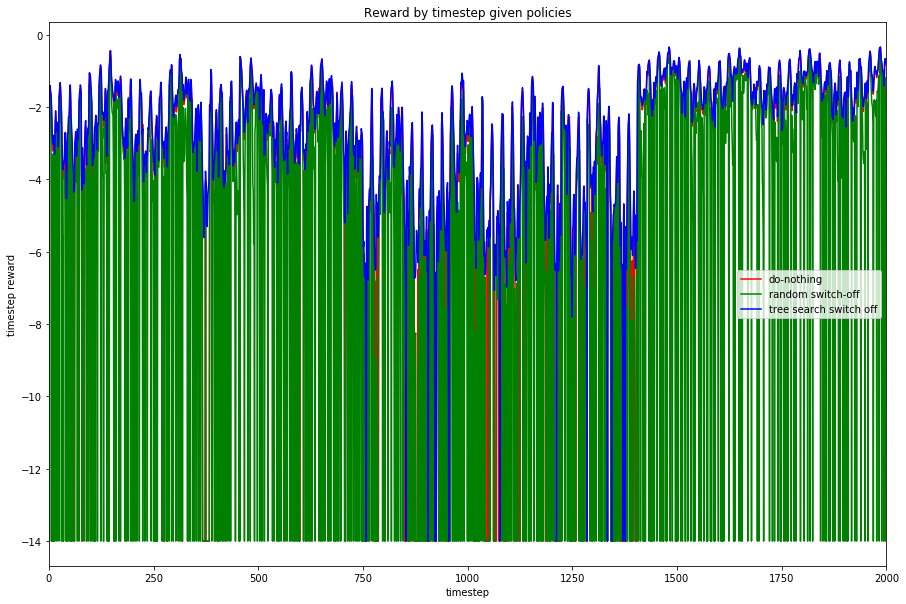

In [42]:
plot_multiple_curves((rewards_do_nothing, rewards_random_switchoff, rewards_greedy_switchoff), 
                     ('do-nothing', 'random switch-off', 'tree search switch off'),
                     title='Reward by timestep given policies',
                     ylabel='timestep reward')

In [43]:
#plot_multiple_histograms((rewards_do_nothing, rewards_random_switchoff, rewards_random_node_split, rewards_greedy_switchoff), 
#                         ('do-nothing', 'random switch-off', 'random node-splitting', 'treesearch switch off'),
#                         title='Reward by timestep given policies',
#                         fitting_curves=True)

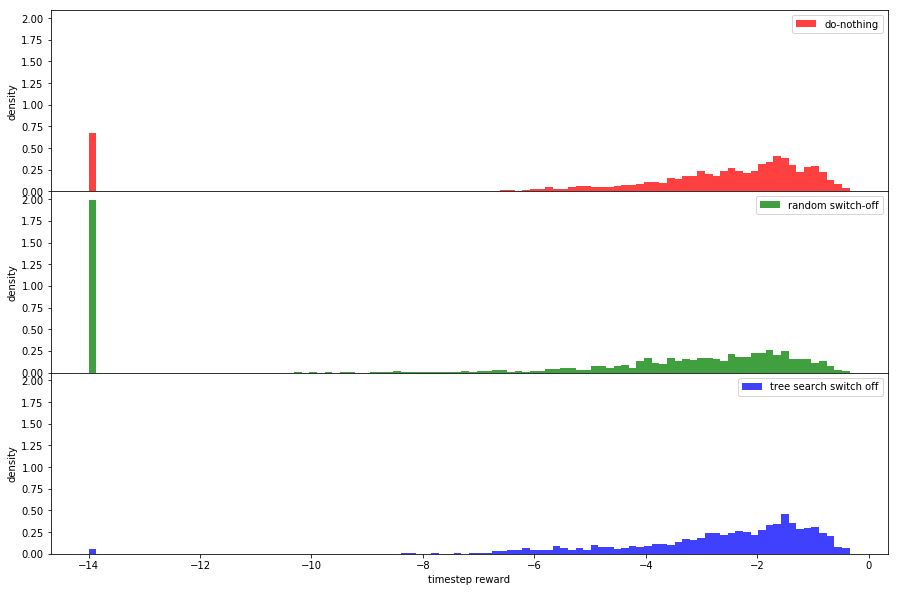

In [44]:
plot_multiple_histograms((rewards_do_nothing, rewards_random_switchoff, rewards_greedy_switchoff), 
                         ('do-nothing', 'random switch-off', 'tree search switch off'),
                         title='Reward by timestep given policies',
                         fitting_curves=False)

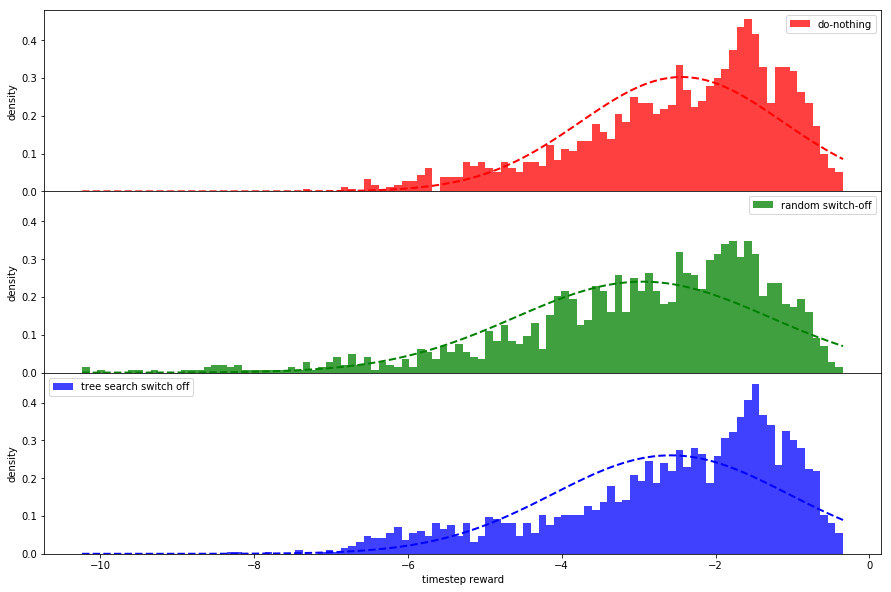

In [45]:
def clean_rewards(rewards):
    # Discard connexity -5 rewards, to plot the rewards when the action did not lead to connexity issues
    return rewards[rewards > env.connexity_exception_reward]

clean_rewards_do_nothing = clean_rewards(rewards_do_nothing)
clean_rewards_random_switchoff = clean_rewards(rewards_random_switchoff)
clean_rewards_greedy_switchoff = clean_rewards(rewards_greedy_switchoff)

plot_multiple_histograms((clean_rewards_do_nothing, 
                          clean_rewards_random_switchoff,
                          clean_rewards_greedy_switchoff), 
                         ('do-nothing', 
                          'random switch-off',
                          'tree search switch off'),
                         title='Reward by timestep given policies',
                         fitting_curves=True)

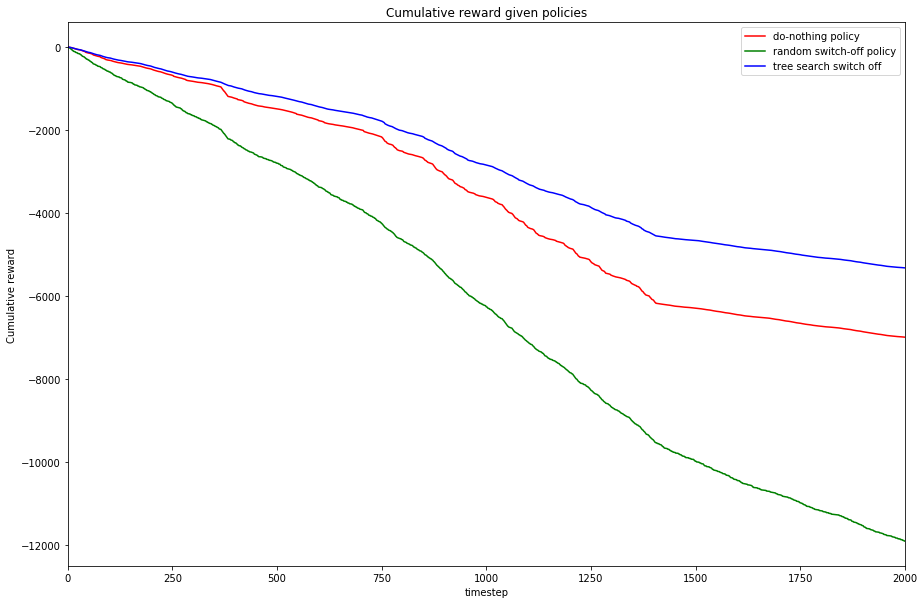

In [46]:
from itertools import accumulate
plot_multiple_curves((list(accumulate(rewards_do_nothing)), 
                      list(accumulate(rewards_random_switchoff)),
                      list(accumulate(rewards_greedy_switchoff)),), 
                     ('do-nothing policy', 
                      'random switch-off policy',
                      'tree search switch off'),
                     title='Cumulative reward given policies',
                     ylabel='Cumulative reward')